<div align="center">
  <h1></h1>
  <h1>Task 2: Fine-tune LLM for Code Generation</h1>
</div>

- **Author:** Vijul Shah

- **Email-id:** vijul1904@gmail.com

## 0. Initialization and Setup

The following code block installs several Python packages using pip:

1. `transformers` for natural language processing tasks.
2. `optimum` for using optimization algorithms.
3. `bitsandbytes` for quantization of the large models.
4. `peft` for paramter efficient fine-tuning.
5. `accelerate` for using gpu related executions.
6. `trl` for Text Representation Learning.
7. `code-bert-score` for evaluating code generation models.

The `-q` flag is used to suppress output messages during installation.<br/>
The `-U` flag is used to ensure that the packages are upgraded to the latest version if they are already installed.

In [1]:
!pip install -q transformers>=4.32.0
!pip install -q optimum
!pip install -q -U bitsandbytes
!pip install -q -U peft
!pip install -q -U accelerate
!pip install -q -U trl
!pip install -q -U evaluate
!pip install -q -U code-bert-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.0/417.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━

The following code block imports necessary Python modules. It also sets up environment variables to suppress certain warnings.

In [ ]:
import re
import os               # Operating System module for interacting with the operating system
import json             # JSON module for working with JSON data
import torch            # PyTorch library for deep learning
import requests         # Requests module for sending HTTP requests
from tqdm import tqdm
from datasets import load_dataset  # Function to load datasets
from transformers import AutoTokenizer  # AutoTokenizer class for tokenization
from sklearn.model_selection import train_test_split  # Function for splitting datasets

import warnings        # Warnings module for controlling warnings
warnings.filterwarnings("ignore")  # Ignore warnings
os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = "true"  # Set environment variable to suppress advisory warnings from transformers library

current_directory = os.getcwd()
print(current_directory)

/content


## 1. Benchmark Dataset

**Task Step Objective**: Load the dataset benchmark and split it in the designed ratio.

Here, we have selected: [python_code_instructions_18k_alpaca](https://huggingface.co/datasets/iamtarun/python_code_instructions_18k_alpaca) as the **Benchmark dataset**.

In [ ]:
dataset_configs = {
    "data_path": f"{current_directory}/data",  # Path to the directory where dataset files will be stored
    "hf_dataset_name": "iamtarun/python_code_instructions_18k_alpaca",  # Name of the Hugging Face dataset
    "train_size": 0.9,  # Size of the training set (as a proportion of the total dataset)
    "test_size": 0.1,   # Size of the test set (as a proportion of the total dataset)
    "max_instances": 600,  # Maximum number of instances to use from the dataset
    "max_length_instances": 800, # Instances which have output length equal to or less than the specified one to use from the dataset
    "random_state": 42  # Random seed for reproducibility
}

**Dataset Processing**

In [ ]:
prompt_dataset_format = """
Generate a python code for the given task description.

### TASK:
{instruction}

### Solution:
```
{solution}
```
"""

The following function takes a dictionary data as input containing keys "instruction" and "output" with corresponding values. It then formats the task instruction and output into a predefined markdown template as above. The formatted instruction, along with the original instruction and output, is returned as a dictionary.

In [ ]:
def format_instruction(data):
    """
    Format instruction function takes a dictionary containing task instruction and output.
    It formats the task instruction and output into the predefined prompt template.

    Args:
    - data (dict): A dictionary containing keys "instruction" and "output" with corresponding values.

    Returns:
    - dict: A dictionary containing formatted instruction text, original instruction, and output.
    """

    # Extract instruction and output from the data dictionary
    instruction = data["instruction"].strip()
    output = data["output"].strip()

    # Format the instruction using the predefined markdown template
    text = prompt_dataset_format.format(instruction=instruction, solution=output)

    # Return formatted instruction along with original instruction and output
    return {
        "text" : text.strip(),
        "instruction": instruction,
        "output": output
    }

In [ ]:
# Define the path to the benchmark dataset directory
benchmark_dataset_path = os.path.join(dataset_configs["data_path"], "benchmark")
# Create the directory if it doesn't exist
os.makedirs(os.path.join(benchmark_dataset_path), exist_ok=True)

The following method performs several operations to process the dataset:

1. It loads the benchmark dataset (`hf_dataset_name`)

2. It filters instances based on the length (`max_length_instances`) of the output variable, ensuring that data samples with potentially lengthy answers are excluded. This is done to maintain a reasonable maximum generation length when creating a synthetic dataset using the hosted LLM, preventing answers that are lengthy and potentially causing API timeouts due to longer response times.

3. The number of instances in the dataset is limited to `max_instances`. This is done by shuffling the dataset and selecting a subset of instances.

4. The instructions in the dataset are formatted using the `format_instruction` function defined earlier.

In [ ]:
def get_benchmark_dataset(dataset_configs, benchmark_dataset_path):

    hf_dataset_path = os.path.join(benchmark_dataset_path, f"{dataset_configs['hf_dataset_name'].split('/')[-1]}.json")

    if os.path.exists(hf_dataset_path):
        with open(hf_dataset_path, encoding='utf-8') as f:
            benchmark_dataset = json.load(f)
            print("benchmark_dataset length =", len(benchmark_dataset))
    else:
        # 1. Load dataset from Hugging Face
        hf_ds = load_dataset(dataset_configs["hf_dataset_name"])
        print("hf_ds = ",hf_ds)

        # Selecting the training split from the loaded dataset
        hf_ds = hf_ds["train"]
        print("hf_ds length before limiting instances =", len(hf_ds))

        # 2. Filtering out samples with output length > specified one
        hf_ds = hf_ds.filter(lambda example: len(example["output"].strip()) <= dataset_configs["max_length_instances"])
        print("hf_ds length after limiting length =", len(hf_ds))

        # 3. Limit the number of instances in the dataset
        hf_ds = hf_ds.shuffle(seed=dataset_configs["random_state"]).select([i for i in range(dataset_configs["max_instances"])])
        print("hf_ds length after limiting instances =", len(hf_ds))

        # 4. Format the dataset
        hf_ds = hf_ds.map(format_instruction, remove_columns=list(hf_ds.features.keys()))
        print("hf_ds (formatted) length =", len(hf_ds))

        # Create a list to store the formatted dataset
        benchmark_dataset = []
        for text_paragraph in hf_ds:
            benchmark_dataset.append(text_paragraph)
        print("benchmark_dataset length =", len(benchmark_dataset))

        with open(hf_dataset_path, 'w', encoding='utf-8') as f:
            json.dump(benchmark_dataset, f, ensure_ascii=False, indent=4)

    return benchmark_dataset

In [ ]:
benchmark_dataset = get_benchmark_dataset(dataset_configs, benchmark_dataset_path)

benchmark_dataset length = 600


Here, as we see, the final benchmark dataset fetched has 600 samples.

**Dataset Splitting**

This code splits the benchmark dataset into training and test sets using the `train_test_split` function from scikit-learn.

In [ ]:
def get_train_test_splits(benchmark_dataset_path, dataset_configs):
    if os.path.exists(os.path.join(benchmark_dataset_path, "train.json")) and os.path.exists(os.path.join(benchmark_dataset_path, "test.json")):
        with open(os.path.join(benchmark_dataset_path, "train.json"), encoding='utf-8') as f:
            bchmrk_train_texts = json.load(f)
        with open(os.path.join(benchmark_dataset_path, "test.json"), encoding='utf-8') as f:
            bchmrk_test_texts = json.load(f)
    else:
        # Splitting the benchmark dataset into training and test sets
        bchmrk_train_texts, bchmrk_test_texts = train_test_split(
            benchmark_dataset,
            train_size=dataset_configs["train_size"],  # Proportion of the dataset to include in the training set
            test_size=dataset_configs["test_size"],    # Proportion of the dataset to include in the test set
            shuffle=True,                              # Shuffle the dataset before splitting
            random_state=dataset_configs["random_state"]  # Random seed for reproducibility
        )

        # Write the training set to a JSON file
        with open(os.path.join(benchmark_dataset_path, "train.json"), 'w', encoding='utf-8') as train_data_output_file:
            json.dump(bchmrk_train_texts, train_data_output_file, ensure_ascii=False, indent=4)

        # Write the test set to a JSON file
        with open(os.path.join(benchmark_dataset_path, "test.json"), 'w', encoding='utf-8') as test_data_output_file:
            json.dump(bchmrk_test_texts, test_data_output_file, ensure_ascii=False, indent=4)

    return bchmrk_train_texts, bchmrk_test_texts

In [ ]:
bchmrk_train_texts, bchmrk_test_texts = get_train_test_splits(benchmark_dataset_path, dataset_configs)
print("bchmrk_train_texts =", len(bchmrk_train_texts))
print("bchmrk_test_texts =", len(bchmrk_test_texts))

bchmrk_train_texts = 540
bchmrk_test_texts = 60


We split the dataset in 90% train and 10% test ratios.

## 2. Pre-trained LLM (Model A)

**Task Step Objective**: Load your selected pre-trained model

Now, let's use the created dataset on a pre-trained LLM.

We will select a Pre-trained LLM: [CodeLlama-7b-hf](https://huggingface.co/codellama/CodeLlama-7b-hf).

This will be our Model A.

In [ ]:
pre_trained_hf_model_name = "codellama/CodeLlama-7b-hf"  # Name of the selected pre-trained Hugging Face model

The memory requirement for a 7 billion parameter model using float32 precision:

$ \text{Memory (GB)} = \frac{7,000,000,000 \times 4}{1024^3}$

$\text{Memory (GB)} = \frac{28,000,000,000}{1024^3} $

$ \text{Memory (GB)} \approx 26.06 \, \text{GB} $

For this reason, I will load the model with **4-bit quantization**. I will use classic 4-bit quantization as described in [QLoRA](https://arxiv.org/pdf/2305.14314.pdf) with `BitsAndBytes`. This will apply to all weights and activations in the model.

Let's start by importing the `BitsAndBytesConfig` and `AutoModelForCausalLM` classes from the transformers library.
These classes are used for configuring and instantiating models (with Quantization) for causal language modeling tasks, respectively.

In [ ]:
from transformers import BitsAndBytesConfig  # Importing BitsAndBytesConfig from the transformers library
from transformers import AutoModelForCausalLM  # Importing AutoModelForCausalLM from the transformers library

**Setting Up Quantization Configuration**

As the Base Model is huge (7 Billion parameters), we need to quantize the model so that it can be loaded on the VRAM in the Colab Env with 1 GPU.

**Quantization Configuration**: An instance of `BitsAndBytesConfig` named `bnb_config` is created with the following parameters:
   - `load_in_4bit`: Specifies to load the pre-trained model in 4-bit quantization mode.
   - `bnb_4bit_use_double_quant`: Indicates to use double quantization in 4-bit mode.
   - `bnb_4bit_quant_type`: Specifies the quantization type as "nf4".
   - `bnb_4bit_compute_dtype`: Specifies the compute datatype as `torch.bfloat16`.

These settings configure the quantization process for the specified pre-trained model, enabling optimized performance and reduced memory usage during training and inference.


In [ ]:
# Setup the quantization configuration using BitsAndBytesConfig
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Loads the pre-trained model in 4-bit quantization mode
    bnb_4bit_use_double_quant=True,  # Uses double quantization in 4-bit mode
    bnb_4bit_quant_type="nf4",  # Specifies the quantization type as "nf4"
    bnb_4bit_compute_dtype=torch.bfloat16  # Specifies the compute datatype as torch.bfloat16
)

**Model Instantiation with Quantization Configuration**

The following code instantiates the selected model (`modelA`) for causal language modeling. This model is configured with quantization settings defined in `bnb_config`.

In [ ]:
modelA = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=pre_trained_hf_model_name,  # Specifies the name or path of the pre-trained model
    quantization_config=bnb_config,  # Specifies the quantization configuration
    device_map="auto"  # Specifies the device mapping strategy as "auto"
)
print(modelA)

config.json:   0%|          | 0.00/637 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32016, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Lla

## 3. Evaluate Model A

**Task Step Objective**: Test model A on the testing dataset using the selected evaluation metric.

In [ ]:
with open(os.path.join(benchmark_dataset_path, "test.json"), encoding='utf-8') as f:
    bchmrk_test_texts = json.load(f)

print("bchmrk_test_texts length = ",len(bchmrk_test_texts))

bchmrk_test_texts length =  60


**Hugging Face Tokenizer Creation**

- Before we give the data to the model, it needs to be converted into token embeddings.

- Here, we will select the tokenizer from Hugging Face library and keep it same as model i.e [CodeLlama-7b-hf](https://huggingface.co/codellama/CodeLlama-7b-hf).

- *Tokenizer Instantiation*: The following function instantiates a tokenizer using the `AutoTokenizer.from_pretrained()` method from the Hugging Face library. The configuration parameters are provided using the `tokenizer_configs` dictionary.


In [ ]:
def HFTokenizer(tokenizer_configs):
    """
    Function to create a tokenizer using the Hugging Face Transformers library.

    Parameters:
        tokenizer_configs (dict): Dictionary containing configuration parameters for tokenizer instantiation.

    Returns:
        tokenizer: Instance of the tokenizer.
    """
    tokenizer = AutoTokenizer.from_pretrained(
        **tokenizer_configs
    )  # Instantiates a tokenizer using the provided configuration parameters
    tokenizer.pad_token = tokenizer.eos_token  # Sets the pad token to be the end-of-sequence token
    tokenizer.padding_side = "right"  # Sets the padding side to be right-aligned
    return tokenizer

According to OpenAI's [tokenization analysis](https://platform.openai.com/tokenizer), approximately 75 words ~= 100 tokens.

And, as we have taken outputs of maximum 800 characters, let's see how many words are equal to 800 characters according to [characters-to-words](https://charactercounter.com/characters-to-words):
It is around 130-160 words.

Thus, we can take around 200 tokens (800 chars ~= 150 (75x2) words ~= 200 (100x2) tokens).

So to be on the safe side and also considering some lenght of instruction prompt, let's keep tokenizer's embedding length and model generation lengths to 256 tokens.

Thus, 256 tokens ~= 192 words ~= 1024 characters.This can cover upto 800 characters from output + upto 224 characters of instructions (i.e 42 words).

Limiting these sizes help us to perform training and evaluation faster.

In [ ]:
tokenizer_configs = {
    "model_max_length": 256,  # Maximum sequence length supported by the tokenizer
    "pretrained_model_name_or_path": "codellama/CodeLlama-7b-hf"  # Name or path of the pre-trained tokenizer model
}

In [ ]:
tokenizer = HFTokenizer(tokenizer_configs)
print("tokenizer = ",len(tokenizer)," | tokenizer_embedding_size = ",tokenizer.model_max_length,"\n")

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

tokenizer =  32016  | tokenizer_embedding_size =  256 



- We'll evaluate ModelA on the test dataset using the `CodeBleu metric`.

- The resulting score will be stored in a dictionary containing all the chosen models throughout the task.

In [ ]:
import code_bert_score

code_bert_scores_path = os.path.join(dataset_configs["data_path"], "eval_results", "code_bert_scores.json")

if os.path.exists(code_bert_scores_path):
    with open(os.path.join(code_bert_scores_path), encoding='utf-8') as f:
        code_bert_scores_dict = json.load(f)
else:
    code_bert_scores_dict = {}

In [ ]:
def get_eval_bert_score(preds_list, refs_list, model_name):

    precision, recall, f1_score, f3_score = code_bert_score.score(
        cands=preds_list,
        refs=refs_list,
        lang='python'
    )

    avg_precision = precision.mean().item()
    avg_recall = recall.mean().item()
    avg_f1_score = f1_score.mean().item()
    avg_f3_score = f3_score.mean().item()

    print("Average precision:", avg_precision)
    print("Average recall:", avg_recall)
    print("Average F1 score:", avg_f1_score)
    print("Average F3 score:", avg_f3_score)

    code_bert_scores_dict[model_name] = {
        "avg_precision": avg_precision,
        "avg_recall": avg_recall,
        "avg_f1_score": avg_f1_score,
        "avg_f3_score": avg_f3_score,

    }

    return code_bert_scores_dict

Methods for Model Evaluation and Saving Results

In [ ]:
def eval_model_on_test_data(model, data=bchmrk_test_texts):
    """
    Function to evaluate the performance of a model on test data.

    Parameters:
        model: Model to be evaluated.
        data (list): List of dictionaries containing test data.

    Returns:
        tuple: A tuple containing lists of predicted outputs and reference outputs.
    """
    instructions_list, outputs_list, preds_list, refs_list = [], [], [], []
    model.eval()

    for data_obj in tqdm(data):
        instruction = data_obj["instruction"]  # Extracting instruction from test data
        target_output = data_obj["output"]     # Extracting target output from test data

        input_ids = tokenizer(instruction, return_tensors='pt').input_ids.cuda()  # Tokenizing instruction
        output_tokens = model.generate(input_ids, max_new_tokens=256, pad_token_id=tokenizer.eos_token_id)[0]  # Generating output tokens

        outputs_list.append(output_tokens)
        instructions_list.append(instruction)
        refs_list.append(target_output)

    for i, outputs in enumerate(tqdm(outputs_list)):
        prompt = instructions_list[i]

        predicted_output = tokenizer.decode(
            outputs.detach().cpu().numpy(),
            skip_special_tokens=True
        )[len(prompt):]

        preds_list.append(predicted_output)

    return preds_list, refs_list

In [ ]:
def write_eval_scores_and_predictions_to_file(preds_list, refs_list, model_name):

    # Define the path to the evaluation results directory
    eval_results_path = os.path.join(dataset_configs["data_path"], "eval_results")
    os.makedirs(os.path.join(eval_results_path), exist_ok=True)

    # Writing evaluation results to a text file.
    with open(f"{eval_results_path}/{model_name}.txt", "a", encoding='utf-8') as file:
        file.write(f"CodeBert Scores = {code_bert_scores_dict[model_name]}\n")
        file.write("="*100 + "\n\n")
        for pred, ref in zip(preds_list, refs_list):
            file.write("REFERENCE:\n{}\n".format(ref))
            file.write("\nPREDICTION:\n{}\n".format(pred))
            file.write("="*100 + "\n")

Model Evaluation and Scores

In [ ]:
preds_list_model_A, refs_list_model_A = eval_model_on_test_data(modelA, bchmrk_test_texts)

100%|██████████| 60/60 [00:00<00:00, 3327.93it/s]


In [ ]:
code_bert_scores_dict = get_eval_bert_score(preds_list_model_A, refs_list_model_A, "model_a")
print(code_bert_scores_dict)

tokenizer_config.json:   0%|          | 0.00/1.54k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/703 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Average precision: 0.6169596910476685
Average recall: 0.69612056016922
Average F1 score: 0.6524550318717957
Average F3 score: 0.6865814924240112
{'model_a': {'avg_precision': 0.6169596910476685, 'avg_recall': 0.69612056016922, 'avg_f1_score': 0.6524550318717957, 'avg_f3_score': 0.6865814924240112}}


In [ ]:
write_eval_scores_and_predictions_to_file(preds_list_model_A, refs_list_model_A, "model_a")

In [ ]:
code_bert_scores_path = os.path.join(dataset_configs["data_path"], "eval_results", "code_bert_scores.json")
with open(code_bert_scores_path, 'w', encoding='utf-8') as file:
    json.dump(code_bert_scores_dict, file, indent=4)

## 4. Create Model B

**Task Step Objective**: Fine-tune model A on the training dataset

In [ ]:
with open(os.path.join(benchmark_dataset_path, "train.json"), encoding='utf-8') as f:
    bchmrk_train_texts = json.load(f)

print("bchmrk_train_texts length = ",len(bchmrk_train_texts))

bchmrk_train_texts length =  540


- To optimize training efficiency and accommodate limited RAM and GPU resources on Colab, we'll employ LoRA to fine-tune the pre-trained CodeLlama model (ModelA) using a single GPU.

- LoRA enables selective updates to only specific layers of the model, avoiding the need to update all 7 billion parameters during the backward pass. This targeted approach accelerates training, making it feasible on a single GPU while conserving resources.

In [ ]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

# Setup LoRA Config
lora_config = LoraConfig(
    r=16,                                                     # Rank of the LoRA matrices A, B
    lora_alpha=64,                                            # Scales the product AB
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],  # Modules to which LoRA will be applied
    lora_dropout=0.1,                                         # Dropout rate to reduce overfitting
    bias="none",                                              # Do not train the bias parameter
    task_type="CAUSAL_LM"                                     # Type of task (causal language modeling)
)

def get_peft_model_a():
  # Prepare model for LoRA training
  peft_model_a = prepare_model_for_kbit_training(modelA)  # This involves float conversions that help stabilize training

  # Get model with unfrozen LoRA layers
  peft_model_a = get_peft_model(peft_model_a, lora_config)  # Retrieves model with unfrozen LoRA layers
  print("model = \n",peft_model_a)

  return peft_model_a

In [ ]:
peft_model_a = get_peft_model_a()
peft_model_a.gradient_checkpointing_enable()    # Store less activations and recompute later
peft_model_a.config.use_cache = False           # Disable using attention output cache. Should be enabled in inference.

model = 
 PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32016, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer)

Next, we will setup the model for training using a Supervised Fine-Tune Trainer.

In [ ]:
from transformers import TrainingArguments
from trl import SFTTrainer

def setup_model_for_finetuning(model_name, model, train_data, validation_data):
    """
    Function to set up a model for fine-tuning using the SFTTrainer from the TRL library.

    Parameters:
        model_name (str): Name of the model.
        train_data (Dataset): Training dataset.
        validation_data (Dataset): Validation dataset.

    Returns:
        trainer: Instance of the SFTTrainer configured for fine-tuning.
    """
    # Training arguments for fine-tuning
    training_arguments = TrainingArguments(
        fp16=True,                           # Training computations in 16 bits
        per_device_train_batch_size=2,       # Batch size
        gradient_accumulation_steps=8,       # Effective batch size (mathematically)
        optim="paged_adamw_32bit",           # Optimizer variant designed for 32-bit GPUs
        learning_rate=3e-5,                  # Learning rate
        lr_scheduler_type="cosine",          # Learning rate scheduler type
        num_train_epochs=1,                  # Number of training epochs
        save_strategy="no",                  # Save model after each epoch
        output_dir=f"{dataset_configs['data_path']}/train_logs/{model_name}", # Directory to save the fine-tuned model
        evaluation_strategy="no",            # Evaluate model after certain number of training steps
        logging_steps=5,                     # Log training progress after each step
        group_by_length=True,                # Group sentences of similar length to minimize padding
        seed=42,                             # Seed for reproducibility
    )

    # Trainer setup for fine-tuning
    trainer = SFTTrainer(
        tokenizer=tokenizer,                 # Tokenizer for tokenizing input text
        model=model,                         # Pre-trained model configured for fine-tuning
        packing=True,                        # Enable packing for efficient training
        dataset_text_field="text",           # Field in dataset containing text data
        train_dataset=train_data,            # Training dataset
        eval_dataset=validation_data,        # Validation dataset
        peft_config=lora_config,             # LoRA configuration for the model
        max_seq_length=256,                 # Maximum sequence length
        args=training_arguments,             # Training arguments for fine-tuning
    )

    return trainer

In [ ]:
peft_model_a = get_peft_model_a()
peft_model_a.gradient_checkpointing_enable()    # Store less activations and recompute later
peft_model_a.config.use_cache = False           # Disable using attention output cache. Should be enabled in inference.

model = 
 PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32016, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer)

In [ ]:
trainer_model_b = setup_model_for_finetuning(
    model_name="model_b",
    model=peft_model_a,
    train_data=bchmrk_train_texts,
    validation_data=bchmrk_test_texts
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
trainer_model_b.train()

{'loss': 1.1354, 'grad_norm': 0.4646211564540863, 'learning_rate': 2.5159223574386117e-05, 'epoch': 0.25806451612903225}
{'loss': 1.1035, 'grad_norm': 0.8364827632904053, 'learning_rate': 1.3761309817915017e-05, 'epoch': 0.5161290322580645}
{'loss': 1.0555, 'grad_norm': 0.6539850234985352, 'learning_rate': 3.162892359054098e-06, 'epoch': 0.7741935483870968}
{'train_runtime': 371.1678, 'train_samples_per_second': 0.835, 'train_steps_per_second': 0.051, 'train_loss': 1.086705483888325, 'epoch': 0.9806451612903225}


TrainOutput(global_step=19, training_loss=1.086705483888325, metrics={'train_runtime': 371.1678, 'train_samples_per_second': 0.835, 'train_steps_per_second': 0.051, 'train_loss': 1.086705483888325, 'epoch': 0.9806451612903225})

In [ ]:
peft_model_path_model_b = os.path.join(dataset_configs["data_path"], "ft_models", "model_b")
trainer_model_b.model.save_pretrained(peft_model_path_model_b)

In [ ]:
del trainer_model_b

## 5. Evaluate Model B

**Task Step Objective**: Test model B on the testing dataset using the selected evaluation metric.

In [ ]:
with open(os.path.join(benchmark_dataset_path, "test.json"), encoding='utf-8') as f:
    bchmrk_test_texts = json.load(f)

print("bchmrk_test_texts length = ",len(bchmrk_test_texts))

bchmrk_test_texts length =  60


In [ ]:
from peft import AutoPeftModelForCausalLM

def get_finetuned_hf_peft_model(peft_model_path):
    """
    Function to load and return a fine-tuned model using the PEFT library.

    Parameters:
        peft_model_path (str): Path to the fine-tuned model saved on disk.

    Returns:
        tuned_model: Fine-tuned model loaded from the specified path.
    """
    tuned_model = AutoPeftModelForCausalLM.from_pretrained(
        pretrained_model_name_or_path=peft_model_path,
        low_cpu_mem_usage=True,         # Reduce CPU memory usage
        torch_dtype=torch.float16,      # Use 16-bit floating point precision
        quantization_config=bnb_config  # Specifies the quantization configuration
    )
    return tuned_model

In [ ]:
peft_model_path_model_b = os.path.join(dataset_configs["data_path"], "ft_models", "model_b")
peft_model_b = get_finetuned_hf_peft_model(peft_model_path_model_b)
print("model = \n",peft_model_b)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

model = 
 PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32016, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer)

In [ ]:
peft_model_b.gradient_checkpointing_enable()    # Store less activations and recompute later
peft_model_b.config.use_cache = True            # Disable using attention output cache. Should be enabled in inference.

In [ ]:
preds_list_model_B, refs_list_model_B = eval_model_on_test_data(peft_model_b, bchmrk_test_texts)

100%|██████████| 60/60 [00:00<00:00, 3566.64it/s]


In [ ]:
code_bert_scores_dict = get_eval_bert_score(preds_list_model_B, refs_list_model_B, "model_b")
print(code_bert_scores_dict)

Average precision: 0.6496725082397461
Average recall: 0.7369462251663208
Average F1 score: 0.6878429651260376
Average F3 score: 0.7260358929634094
{'model_a': {'avg_precision': 0.6169596910476685, 'avg_recall': 0.69612056016922, 'avg_f1_score': 0.6524550318717957, 'avg_f3_score': 0.6865814924240112}, 'model_b': {'avg_precision': 0.6496725082397461, 'avg_recall': 0.7369462251663208, 'avg_f1_score': 0.6878429651260376, 'avg_f3_score': 0.7260358929634094}}


In [ ]:
write_eval_scores_and_predictions_to_file(preds_list_model_B, refs_list_model_B, "model_b")

In [ ]:
del peft_model_b

In [ ]:
code_bert_scores_path = os.path.join(dataset_configs["data_path"], "eval_results", "code_bert_scores.json")
with open(code_bert_scores_path, 'w', encoding='utf-8') as file:
    json.dump(code_bert_scores_dict, file, indent=4)

## 6. Synthetic Dataset

**Task Step Objective**: Use the designed prompt to generate a new synthesised dataset that has the
nature and 3 times the size of the training dataset using the supported AWS
model.

In [ ]:
# Constructing the path to store synthetic datasets within the dataset configuration's data path.
synthetic_dataset_path = os.path.join(dataset_configs["data_path"], "synthetic")

# Creating the directory if it doesn't exist already.
os.makedirs(synthetic_dataset_path, exist_ok=True)

Now, let's use the benchmark dataset's instructions and create a new synthetic dataset by prompting the AWS hosted model `meta.llama2-70b-chat-v1` using API requests.

In [ ]:
# This code defines an AWS_API_KEY and sets up an AWS API Gateway endpoint and a Lambda function for generating text.
AWS_API_KEY = "YOUR_AWS_HOSTED_MODEL_API_KEY"

# AWS API Gateway endpoint and Lambda function URL for text generation.
aws_api_gateway = "YOU_AWS_GATEWAY_ENDPOINT"
aws_lambda_function = f"{aws_api_gateway}/YOUR_AWS_FUNCTION_NAME"

# This function llama_generate is responsible for generating text based on a given prompt using an external service.
# It sends a POST request to the AWS Lambda function with the provided parameters and returns the generated text.
def llama_generate(
    prompt,
    api_token,
    max_gen_len=1024,
    temperature=0.2,
    top_p=0.9
):
    print("length of given prompt before resize: ",len(prompt))
    prompt = prompt[:4096] # Ensure the prompt lenght does not exceed the model's context length
    print("length of given prompt after resize: ",len(prompt))

    # Body of the POST request containing parameters for text generation.
    body = {
        "prompt": prompt,
        "max_gen_len": max_gen_len,
        "temperature": temperature,
        "top_p": top_p,
        "api_token": api_token
    }
    # Sending a POST request to the AWS Lambda function endpoint with the JSON body.
    res = requests.post(aws_lambda_function, json=body)
    # Parsing the response JSON and extracting the generated text.
    response = json.loads(res.text)
    print("response = ",response)
    return response["body"]["generation"]

**Prompt Format**

As we need to create the dataset which is 3 times the size of the benchmark dataset, we will craft/engineer a prompt for that as shown below.

First, we will impute the model with a personality of an expert python coder so that it can start chatting in context of the tasks associated with python.

Next, we will keep the system instruction inside `[INST]` and `[/INST]` block so that it can easily get the required context from the instruction block and thus, it can also understand the desired output format.
(Idea is taken and modified from here: [how-to-prompt-llama2](https://huggingface.co/blog/llama2#how-to-prompt-llama-2))

Moreover, the reason to use such formatting is becuase we can easily extract the output tasks by mathcing regular expressions in the output text string.

In [ ]:
prompt_synthetic_data_pass1 = """
[INST]
You are an expert python coder who is skillful in creating 3 different python tasks with short task descriptions and python code which are similar in nature to the given task:

TASK: {user_input}

[/INST]

Limit your answer to 800 words or less. Answer in the following format:

TASK 1: <TASK_DESCRIPTION/>
```python
	<PYTHON_CODE/>
```

TASK 2: <TASK_DESCRIPTION/>
```python
	<PYTHON_CODE/>
```

TASK 3: <TASK_DESCRIPTION/>
```python
	<PYTHON_CODE/>
```

Expert:
"""

This prompt will take each instruction as input and outputs a text string containing 3 tasks and their corresponding python codes, 'almost' exactly in the format as specified above.

'almost': because there can be cases where model hallucinated a bit and slightly changed the format or went out of specified maximum generation text length.

In [ ]:
def get_synthetic_dataset(bchmrk_train_texts, prompt_synthetic_data, force_new=False):

    generated_raw_texts = []

    if os.path.exists(f"{synthetic_dataset_path}/llm_generted_texts.json") and force_new == False:
        with open(os.path.join(synthetic_dataset_path, "llm_generted_texts.json"), encoding='utf-8') as f:
            generated_raw_texts = json.load(f)
    elif os.path.exists(f"{synthetic_dataset_path}/llm_outputs.txt") and force_new == False:

        with open(f"{synthetic_dataset_path}/llm_outputs.txt", 'r', encoding='utf-8') as file:
            lines = file.readlines()

        current_content = ""
        # Iterate through the lines
        for line in lines:
            # Check if the line starts with the instance delimiter
            if line.startswith("============================== INSTANCE:"):
                # If it's not the first instance, add the current content to the contents list
                if current_content:
                    generated_raw_texts.append(current_content)
                    current_content = ""
            else:
                # If it's not the instance delimiter and not an empty line, append the line to the current content
                if line.strip():
                    current_content += line

        # Append the last content to the contents list
        if current_content:
            generated_raw_texts.append(current_content)
    else:
        with open(f"{synthetic_dataset_path}/llm_outputs.txt", "a", encoding='utf-8') as file:
            # Iterating over benchmark training texts to generate synthetic texts.
            for i, benchmark_train_obj in enumerate(bchmrk_train_texts):

                # Printing instance information.
                print(f"\n============================== INSTANCE: {i} =====================================")
                file.write(f"\n============================== INSTANCE: {i} =====================================")

                instruction = benchmark_train_obj["instruction"]
                print("instruction: ",instruction,"\n")
                file.write("instruction: ",instruction,"\n")

                # Generating synthetic text.
                prompt = prompt_synthetic_data.format(user_input=str(instruction))
                synthetic_text_generated = llama_generate(prompt, AWS_API_KEY)

                # Appending the generated synthetic text to the list.
                generated_raw_texts.append(synthetic_text_generated)

                # Printing the generated synthetic text.
                print("\nsynthetic_text_generated = \n", synthetic_text_generated)
                file.write("\nsynthetic_text_generated = \n", synthetic_text_generated)

        # Defining the file path to save the generated synthetic texts in JSON format.
        synthetic_texts_raw_file = f"{synthetic_dataset_path}/llm_generted_texts.json"

        # Writing the synthetic training texts to a JSON file.
        with open(synthetic_texts_raw_file, "w", encoding='utf-8') as output_file:
            json.dump(generated_raw_texts, output_file)

        # Printing a message indicating that the LLM generated raw texts have been saved.
        print("Saved LLM generated raw texts!!!")
        print("generated_raw_texts length = ",len(generated_raw_texts))

    return generated_raw_texts

In [ ]:
synthetic_train_texts_raw = get_synthetic_dataset(bchmrk_train_texts, prompt_synthetic_data_pass1)
print("bchmrk_train_texts = ", len(bchmrk_train_texts))
print("synthetic_train_texts_raw = ", len(synthetic_train_texts_raw))

bchmrk_train_texts =  540
synthetic_train_texts_raw =  540


### Extract Tasks and Codes from the Synthetic Dataset

As we had told the model to give output in a spefic format for each given instruction, it can easily be extracted from a text string using regular expression.

In [ ]:
def extract_tasks_and_codes(text):

    # Regular expression pattern to extract task description and Python code
    pattern = r'TASK \d+:(.*?)```python\s*(.*?)\s*(?=```|\Z)'

    # Find all matches
    matches = re.findall(pattern, text, re.IGNORECASE | re.DOTALL)

    # Initialize lists to store task descriptions and Python code blocks.
    task_descriptions = []
    python_codes = []

    # Extract task descriptions and Python code blocks from matches
    for match in matches:
        td = match[0].strip()
        if len(td) > 0:
            task_descriptions.append(td)
        pc = match[1].strip()
        if len(pc) > 0:
            python_codes.append(pc)

    return task_descriptions, python_codes

In [ ]:
def extract_tasks_and_codes_backup(text):
    """
    Extracts task descriptions and Python code blocks from a given text.

    Args:
    - text (str): The text containing task descriptions and Python code blocks.

    Returns:
    - task_descriptions (list): A list of task descriptions extracted from the text.
    - python_codes (list): A list of Python code blocks extracted from the text.
    """

    # Regular expression pattern for matching task descriptions and Python code blocks.
    task_pattern_pass1 = r'TASK 1:(.*?)Task 2'
    task_pattern_pass2 = r'TASK 2:(.*?)Task 3'
    task_pattern_pass3 = r'TASK 3:(.*?)(?=Task 1|\Z)'

    task_pattern_pass4 = r'```python(.*?)(?=```|\Z)'

    # Initialize lists to store task descriptions and Python code blocks.
    task_descriptions = []
    python_codes = []

    matches1 = re.findall(task_pattern_pass1, text, re.IGNORECASE | re.DOTALL)
    if len(matches1) > 0:
        td = matches1[0].strip()
        if len(td) > 0:
            task_descriptions.append(td)

    matches2 = re.findall(task_pattern_pass2, text, re.IGNORECASE | re.DOTALL)
    if len(matches2) > 0:
        td = matches2[0].strip()
        if len(td) > 0:
            task_descriptions.append(td)

    matches3 = re.findall(task_pattern_pass3, text, re.IGNORECASE | re.DOTALL)
    if len(matches3) > 0:
        td = matches3[0].strip()
        if len(td) > 0:
            task_descriptions.append(td)

    matches4 = re.findall(task_pattern_pass4, text, re.IGNORECASE | re.DOTALL)
    for match in matches4:
        pc = match.strip()
        if len(pc) > 0:
            python_codes.append(pc)

    return task_descriptions, python_codes

In [ ]:
def calc_synthetic_data_instances(bchmrk_train_texts, synthetic_train_texts, extracted_synthetic_train_texts_instance_ids, left_out_synthetic_train_texts_instance_ids):
    # Printing the total number of benchmark texts (original data instances downloaded from hugging face dataset)
    print("bchmrk_train_texts = ", len(bchmrk_train_texts))

    # Printing the total number of synthetic training texts that are extracted.
    print("synthetic_train_texts =", len(synthetic_train_texts))
    print("extracted_synthetic_train_texts_instance_ids =", len(extracted_synthetic_train_texts_instance_ids))

    # Printing the total number of synthetic training texts that are left out (i.e not extracted due to bad output from LLM)
    print("left_out_synthetic_train_texts_instance_ids =", len(left_out_synthetic_train_texts_instance_ids))

    print("Total Desired Texts Achieved =", len(synthetic_train_texts), "out of", len(bchmrk_train_texts)*3 ,"| Total Left =",len(left_out_synthetic_train_texts_instance_ids)*3)

In [ ]:
synthetic_train_texts = []
extracted_synthetic_train_texts_instance_ids = []
left_out_synthetic_train_texts_instance_ids = []

# Iterating over synthetic training texts to extract tasks and codes.
for i, synthetic_text in enumerate(synthetic_train_texts_raw):

    # Extracting tasks and codes from the synthetic text.
    tasks, codes = extract_tasks_and_codes(synthetic_text)

    if (len(tasks) == len(codes)) and (len(tasks) == 3 and len(codes) == 3):
        for i, _ in enumerate(tasks[:3]):
            synthetic_text_obj = format_instruction({
                "instruction": tasks[i],
                "output": codes[i]
            })
            synthetic_train_texts.append(synthetic_text_obj)
        extracted_synthetic_train_texts_instance_ids.append(i)
    elif (len(tasks) == len(codes)) and (len(tasks) > 3 and len(codes) > 3):
        for i, _ in enumerate(tasks[-3:]):
            synthetic_text_obj = format_instruction({
                "instruction": tasks[i],
                "output": codes[i]
            })
            synthetic_train_texts.append(synthetic_text_obj)
        extracted_synthetic_train_texts_instance_ids.append(i)
    elif (len(tasks) == len(codes)) and (len(tasks) == 2 and len(codes) == 2):
        for i, _ in enumerate(range(0,3)):
            if i == 2:
                set_i = 0
            else:
                set_i = i
            synthetic_text_obj = format_instruction({
                "instruction": tasks[set_i],
                "output": codes[set_i]
            })
            synthetic_train_texts.append(synthetic_text_obj)
        extracted_synthetic_train_texts_instance_ids.append(i)
    elif (len(tasks) == len(codes)) and (len(tasks) == 1 and len(codes) == 1):
        for _, _ in enumerate(range(0,3)):
            synthetic_text_obj = format_instruction({
                "instruction": tasks[0],
                "output": codes[0]
            })
            synthetic_train_texts.append(synthetic_text_obj)
        extracted_synthetic_train_texts_instance_ids.append(i)
    else:
        tasks, codes = extract_tasks_and_codes_backup(synthetic_text)
        if (len(tasks) == 3 and len(codes) == 3):
            for i, _ in enumerate(tasks[:3]):
                synthetic_text_obj = format_instruction({
                    "instruction": tasks[i],
                    "output": codes[i]
                })
                synthetic_train_texts.append(synthetic_text_obj)
            extracted_synthetic_train_texts_instance_ids.append(i)
        else:
            print(len(tasks), len(codes))
            left_out_synthetic_train_texts_instance_ids.append(i)

calc_synthetic_data_instances(bchmrk_train_texts, synthetic_train_texts, extracted_synthetic_train_texts_instance_ids, left_out_synthetic_train_texts_instance_ids)

3 0
3 0
bchmrk_train_texts =  540
synthetic_train_texts = 1614
extracted_synthetic_train_texts_instance_ids = 538
left_out_synthetic_train_texts_instance_ids = 2
Total Desired Texts Achieved = 1614 out of 1620 | Total Left = 6


In [ ]:
prompt_synthetic_data_backup = """
[INST]
You are an expert python coder who is skillful in creating 3 different python tasks with short task descriptions and python code which are similar in nature to the given task:

TASK: {user_input}
```python
	{known_solution}
```
[/INST]

Limit your answer to 800 words or less. Answer in the following format:

TASK 1: <TASK_DESCRIPTION/>
```python
	<PYTHON_CODE/>
```

TASK 2: <TASK_DESCRIPTION/>
```python
	<PYTHON_CODE/>
```

TASK 3: <TASK_DESCRIPTION/>
```python
	<PYTHON_CODE/>
```

Expert:
"""

In [ ]:
def create_synthetic_data_with_backup_prompt(left_out_id_selected, bchmrk_train_texts, synthetic_train_texts, extracted_synthetic_train_texts_instance_ids, left_out_synthetic_train_texts_instance_ids):

    data_backup1 = bchmrk_train_texts[left_out_id_selected]

    prompt_backup1 = prompt_synthetic_data_backup.format(user_input=str(data_backup1["instruction"]), known_solution=str(data_backup1["output"]))

    synthetic_text_generated_backup1 = llama_generate(prompt_backup1, AWS_API_KEY)
    print(synthetic_text_generated_backup1)

    tasks_backup1, codes_backup1 = extract_tasks_and_codes(synthetic_text_generated_backup1)
    print(len(tasks), len(codes))

    if (len(tasks) == 3 and len(codes) == 3):

        extracted_synthetic_train_texts_instance_ids.append(left_out_id_selected)

        for i, _ in enumerate(tasks_backup1[:3]):
            synthetic_text_obj = format_instruction({
                "instruction": tasks_backup1[i],
                "output": codes_backup1[i]
            })
            synthetic_train_texts.append(synthetic_text_obj)

        left_out_synthetic_train_texts_instance_ids.remove(left_out_id_selected)

    return bchmrk_train_texts, synthetic_train_texts, extracted_synthetic_train_texts_instance_ids, left_out_synthetic_train_texts_instance_ids

In [ ]:
left_out_id_selected = left_out_synthetic_train_texts_instance_ids[0]

bchmrk_train_texts, synthetic_train_texts, extracted_synthetic_train_texts_instance_ids, left_out_synthetic_train_texts_instance_ids = create_synthetic_data_with_backup_prompt(left_out_id_selected, bchmrk_train_texts, synthetic_train_texts, extracted_synthetic_train_texts_instance_ids, left_out_synthetic_train_texts_instance_ids)

calc_synthetic_data_instances(bchmrk_train_texts, synthetic_train_texts, extracted_synthetic_train_texts_instance_ids, left_out_synthetic_train_texts_instance_ids)

In [ ]:
left_out_id_selected = left_out_synthetic_train_texts_instance_ids[0]

bchmrk_train_texts, synthetic_train_texts, extracted_synthetic_train_texts_instance_ids, left_out_synthetic_train_texts_instance_ids = create_synthetic_data_with_backup_prompt(left_out_id_selected, bchmrk_train_texts, synthetic_train_texts, extracted_synthetic_train_texts_instance_ids, left_out_synthetic_train_texts_instance_ids)

calc_synthetic_data_instances(bchmrk_train_texts, synthetic_train_texts, extracted_synthetic_train_texts_instance_ids, left_out_synthetic_train_texts_instance_ids)

In [ ]:
# Writing the synthetic training texts to a JSON file.
with open(os.path.join(synthetic_dataset_path, "train.json"), 'w', encoding='utf-8') as output_file:
    json.dump(synthetic_train_texts, output_file, ensure_ascii=False, indent=4)

print(f"Saved Synthetic Data: {len(synthetic_train_texts)}!!!")

## 7. Create Model C

**Task Step Objective**: Fine-tune model A on the new synthesised dataset.

In [ ]:
with open(os.path.join(synthetic_dataset_path, "train.json"), encoding='utf-8') as f:
    synthetic_train_texts = json.load(f)

with open(os.path.join(benchmark_dataset_path, "test.json"), encoding='utf-8') as f:
    bchmrk_test_texts = json.load(f)

print("bchmrk_test_texts length = ",len(bchmrk_test_texts))
print("synthetic_train_texts length = ",len(synthetic_train_texts))

bchmrk_test_texts length =  60
synthetic_train_texts length =  1620


In [ ]:
peft_model_a = get_peft_model_a()
peft_model_a.gradient_checkpointing_enable()    # Store less activations and recompute later
peft_model_a.config.use_cache = False           # Disable using attention output cache. Should be enabled in inference.

model = 
 PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32016, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer)

In [ ]:
trainer_model_c = setup_model_for_finetuning(
    model_name="model_c",
    model=peft_model_a,
    train_data=synthetic_train_texts,
    validation_data=bchmrk_test_texts
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
trainer_model_c.train()

{'loss': 1.1086, 'grad_norm': 0.44259190559387207, 'learning_rate': 2.957717352485313e-05, 'epoch': 0.07547169811320754}
{'loss': 1.0036, 'grad_norm': 0.4494656026363373, 'learning_rate': 2.8332531729823853e-05, 'epoch': 0.1509433962264151}
{'loss': 0.909, 'grad_norm': 0.3198188543319702, 'learning_rate': 2.6336243615313876e-05, 'epoch': 0.22641509433962265}
{'loss': 0.8565, 'grad_norm': 0.2890529930591583, 'learning_rate': 2.3700853643567973e-05, 'epoch': 0.3018867924528302}
{'loss': 0.8003, 'grad_norm': 0.25510507822036743, 'learning_rate': 2.0574936834904913e-05, 'epoch': 0.37735849056603776}
{'loss': 0.7863, 'grad_norm': 0.3230634331703186, 'learning_rate': 1.713472257409928e-05, 'epoch': 0.4528301886792453}
{'loss': 0.7489, 'grad_norm': 0.3039465844631195, 'learning_rate': 1.3574159350437264e-05, 'epoch': 0.5283018867924528}
{'loss': 0.735, 'grad_norm': 0.2723315358161926, 'learning_rate': 1.0093980550238676e-05, 'epoch': 0.6037735849056604}
{'loss': 0.721, 'grad_norm': 0.27292409

TrainOutput(global_step=66, training_loss=0.8106850990743348, metrics={'train_runtime': 1290.0372, 'train_samples_per_second': 0.821, 'train_steps_per_second': 0.051, 'train_loss': 0.8106850990743348, 'epoch': 0.9962264150943396})

In [ ]:
peft_model_path_model_c = os.path.join(dataset_configs["data_path"], "ft_models", "model_c")
trainer_model_c.model.save_pretrained(peft_model_path_model_c)

In [ ]:
del trainer_model_c

## 8. Evaluate Model C

**Task Step Objective**: Test model C on the testing dataset using the selected evaluation metric.

In [ ]:
with open(os.path.join(benchmark_dataset_path, "test.json"), encoding='utf-8') as f:
    bchmrk_test_texts = json.load(f)

print("bchmrk_test_texts length = ",len(bchmrk_test_texts))

bchmrk_test_texts length =  60


In [ ]:
peft_model_path_model_c = os.path.join(dataset_configs["data_path"], "ft_models", "model_c")
peft_model_c = get_finetuned_hf_peft_model(peft_model_path_model_c)
print("model = \n",peft_model_c)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

model = 
 PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32016, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer)

In [ ]:
peft_model_c.gradient_checkpointing_enable()    # Store less activations and recompute later
peft_model_c.config.use_cache = True            # Disable using attention output cache. Should be enabled in inference.

In [ ]:
preds_list_model_C, refs_list_model_C = eval_model_on_test_data(peft_model_c, bchmrk_test_texts)

100%|██████████| 60/60 [00:00<00:00, 5361.05it/s]


In [ ]:
code_bert_scores_dict = get_eval_bert_score(preds_list_model_C, refs_list_model_C, "model_c")
print(code_bert_scores_dict)

Average precision: 0.7421875
Average recall: 0.7807868123054504
Average F1 score: 0.7580033540725708
Average F3 score: 0.7755858898162842
{'model_a': {'avg_precision': 0.6169596910476685, 'avg_recall': 0.69612056016922, 'avg_f1_score': 0.6524550318717957, 'avg_f3_score': 0.6865814924240112}, 'model_b': {'avg_precision': 0.6496725082397461, 'avg_recall': 0.7369462251663208, 'avg_f1_score': 0.6878429651260376, 'avg_f3_score': 0.7260358929634094}, 'model_c': {'avg_precision': 0.7421875, 'avg_recall': 0.7807868123054504, 'avg_f1_score': 0.7580033540725708, 'avg_f3_score': 0.7755858898162842}}


In [ ]:
write_eval_scores_and_predictions_to_file(preds_list_model_C, refs_list_model_C, "model_c")

In [ ]:
del peft_model_c

In [ ]:
code_bert_scores_path = os.path.join(dataset_configs["data_path"], "eval_results", "code_bert_scores.json")
with open(code_bert_scores_path, 'w', encoding='utf-8') as file:
    json.dump(code_bert_scores_dict, file, indent=4)

## 9. Combined Dataset

**Task Step Objective**: Combine the training dataset and the synthesised dataset and shuffle them with
suitable seeds.

In [ ]:
import random

combined_train_texts = bchmrk_train_texts + synthetic_train_texts
print("combined_train_texts = ",len(combined_train_texts))

random.seed(dataset_configs["random_state"])
random.shuffle(combined_train_texts)

combined_dataset_path = os.path.join(dataset_configs["data_path"],"combined")
os.makedirs(combined_dataset_path, exist_ok=True)

with open(os.path.join(combined_dataset_path, "train.json"), 'w', encoding='utf-8') as output_file:
    json.dump(combined_train_texts, output_file, ensure_ascii=False, indent=4)

combined_train_texts =  2160


## 10. Create Model D

**Task Step Objective**: Fine-tune model A on the new Combined dataset.

In [ ]:
with open(os.path.join(combined_dataset_path, "train.json"), encoding='utf-8') as f:
    combined_train_texts = json.load(f)

with open(os.path.join(benchmark_dataset_path, "test.json"), encoding='utf-8') as f:
    bchmrk_test_texts = json.load(f)

print("bchmrk_test_texts length = ",len(bchmrk_test_texts))
print("combined_train_texts length = ",len(combined_train_texts))

bchmrk_test_texts length =  60
combined_train_texts length =  2160


In [ ]:
peft_model_a = get_peft_model_a()
peft_model_a.gradient_checkpointing_enable()    # Store less activations and recompute later
peft_model_a.config.use_cache = False           # Disable using attention output cache. Should be enabled in inference.

model = 
 PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32016, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer)

In [ ]:
trainer_model_d = setup_model_for_finetuning(
    model_name="model_d",
    model=peft_model_a,
    train_data=combined_train_texts,
    validation_data=bchmrk_test_texts
)

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
trainer_model_d.train()

{'loss': 1.1405, 'grad_norm': 0.5443899035453796, 'learning_rate': 2.974459649525853e-05, 'epoch': 0.058394160583941604}
{'loss': 1.0819, 'grad_norm': 0.4689757525920868, 'learning_rate': 2.8987083441065335e-05, 'epoch': 0.11678832116788321}
{'loss': 1.0013, 'grad_norm': 0.28759968280792236, 'learning_rate': 2.7753257035944216e-05, 'epoch': 0.17518248175182483}
{'loss': 0.9357, 'grad_norm': 0.24596841633319855, 'learning_rate': 2.6085133758309887e-05, 'epoch': 0.23357664233576642}
{'loss': 0.8512, 'grad_norm': 0.31515154242515564, 'learning_rate': 2.4039519545688848e-05, 'epoch': 0.291970802919708}
{'loss': 0.8623, 'grad_norm': 0.3140440285205841, 'learning_rate': 2.1686075336648075e-05, 'epoch': 0.35036496350364965}
{'loss': 0.843, 'grad_norm': 0.3030182719230652, 'learning_rate': 1.9104944851081247e-05, 'epoch': 0.40875912408759124}
{'loss': 0.8216, 'grad_norm': 0.24802522361278534, 'learning_rate': 1.638402539194953e-05, 'epoch': 0.46715328467153283}
{'loss': 0.7979, 'grad_norm': 0.

TrainOutput(global_step=85, training_loss=0.8425139791825238, metrics={'train_runtime': 1660.0386, 'train_samples_per_second': 0.825, 'train_steps_per_second': 0.051, 'train_loss': 0.8425139791825238, 'epoch': 0.9927007299270073})

In [ ]:
peft_model_path_model_d = os.path.join(dataset_configs["data_path"], "ft_models", "model_d")
trainer_model_d.model.save_pretrained(peft_model_path_model_d)

In [ ]:
del trainer_model_d

## 11. Evaluate Model D

**Task Step Objective**: Test model D on the testing dataset using the selected evaluation metric.

In [ ]:
with open(os.path.join(benchmark_dataset_path, "test.json"), encoding='utf-8') as f:
    bchmrk_test_texts = json.load(f)

print("bchmrk_test_texts length = ",len(bchmrk_test_texts))

bchmrk_test_texts length =  60


In [ ]:
peft_model_path_model_d = os.path.join(dataset_configs["data_path"], "ft_models", "model_d")
peft_model_d = get_finetuned_hf_peft_model(peft_model_path_model_d)
print("model = \n",peft_model_d)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

model = 
 PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32016, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer)

In [ ]:
peft_model_d.gradient_checkpointing_enable()    # Store less activations and recompute later
peft_model_d.config.use_cache = True            # Disable using attention output cache. Should be enabled in inference.

In [ ]:
preds_list_model_D, refs_list_model_D = eval_model_on_test_data(peft_model_d, bchmrk_test_texts)

100%|██████████| 60/60 [00:00<00:00, 3327.98it/s]


In [ ]:
code_bert_scores_dict = get_eval_bert_score(preds_list_model_D, refs_list_model_D, "model_d")
print(code_bert_scores_dict)

Average precision: 0.8190996646881104
Average recall: 0.7882862687110901
Average F1 score: 0.801009476184845
Average F3 score: 0.7903977632522583
{'model_a': {'avg_precision': 0.6169596910476685, 'avg_recall': 0.69612056016922, 'avg_f1_score': 0.6524550318717957, 'avg_f3_score': 0.6865814924240112}, 'model_b': {'avg_precision': 0.6496725082397461, 'avg_recall': 0.7369462251663208, 'avg_f1_score': 0.6878429651260376, 'avg_f3_score': 0.7260358929634094}, 'model_c': {'avg_precision': 0.7421875, 'avg_recall': 0.7807868123054504, 'avg_f1_score': 0.7580033540725708, 'avg_f3_score': 0.7755858898162842}, 'model_d': {'avg_precision': 0.8190996646881104, 'avg_recall': 0.7882862687110901, 'avg_f1_score': 0.801009476184845, 'avg_f3_score': 0.7903977632522583}}


In [ ]:
write_eval_scores_and_predictions_to_file(preds_list_model_D, refs_list_model_D, "model_d")

In [ ]:
del peft_model_d

In [ ]:
code_bert_scores_path = os.path.join(dataset_configs["data_path"], "eval_results", "code_bert_scores.json")
with open(code_bert_scores_path, 'w', encoding='utf-8') as file:
    json.dump(code_bert_scores_dict, file, indent=4)

## 12. Visualisations

**Task Step Objective**: Plot the right visualisation to show all models' performance.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define a function to visualize the scores
def plot_code_bert_scores(score_dict, save_path=None):
    # Get the list of model names and the number of models
    model_names = list(score_dict.keys())
    num_models = len(model_names)

    # Extract the scores for each model
    precision_scores = [score_dict[model]["avg_precision"] for model in model_names]
    recall_scores = [score_dict[model]["avg_recall"] for model in model_names]
    f1_scores = [score_dict[model]["avg_f1_score"] for model in model_names]
    f3_scores = [score_dict[model]["avg_f3_score"] for model in model_names]

    # Set the x-axis positions for the bars
    x = np.arange(num_models)

    # Define the width of the bars
    bar_width = 0.2

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(x - 1.5 * bar_width, precision_scores, bar_width, label='Precision')
    plt.bar(x - 0.5 * bar_width, recall_scores, bar_width, label='Recall')
    plt.bar(x + 0.5 * bar_width, f1_scores, bar_width, label='F1 Score')
    plt.bar(x + 1.5 * bar_width, f3_scores, bar_width, label='F3 Score')

    # Add labels, title, and legend
    plt.xlabel("Model Name")
    plt.ylabel("Scores")
    plt.title("CodeBert Metrics for Different Models")
    plt.xticks(x, model_names)
    plt.legend()

    if save_path:
        plt.savefig(save_path)

    # Display the plot
    plt.show()

In [ ]:
code_bert_scores_path = os.path.join(dataset_configs["data_path"], "eval_results", "code_bert_scores.json")
with open(os.path.join(code_bert_scores_path), encoding='utf-8') as f:
    code_bert_scores_dict = json.load(f)

In [ ]:
code_bert_scores_dict

{'model_a': {'avg_precision': 0.6169596910476685,
  'avg_recall': 0.69612056016922,
  'avg_f1_score': 0.6524550318717957,
  'avg_f3_score': 0.6865814924240112},
 'model_b': {'avg_precision': 0.6496725082397461,
  'avg_recall': 0.7369462251663208,
  'avg_f1_score': 0.6878429651260376,
  'avg_f3_score': 0.7260358929634094},
 'model_c': {'avg_precision': 0.7421875,
  'avg_recall': 0.7807868123054504,
  'avg_f1_score': 0.7580033540725708,
  'avg_f3_score': 0.7755858898162842},
 'model_d': {'avg_precision': 0.8190996646881104,
  'avg_recall': 0.7882862687110901,
  'avg_f1_score': 0.801009476184845,
  'avg_f3_score': 0.7903977632522583}}

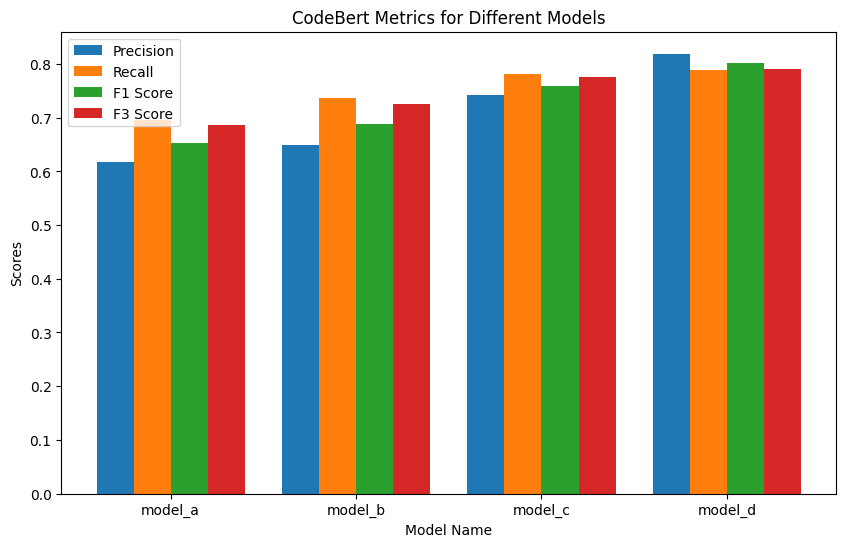

In [ ]:
plot_code_bert_scores(code_bert_scores_dict)

## Bonus: Frontend

In [2]:
!pip install -q streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00


In [3]:
import os
current_directory = os.getcwd()
frontend_dir = f"{current_directory}/cg_code_buddy"
os.makedirs(frontend_dir, exist_ok=True)

In [4]:
app_file_str = """
import config
import streamlit as st
from chat import chat_area
from sidebar import sidebar
from session import initialize_session_states

def main():

    st.set_page_config(layout="wide")
    st.title(**config.TITLE_NAME)
    st.caption(config.CAPTION)

    initialize_session_states(session_state=st.session_state)
    sidebar()
    chat_area()

if __name__ == "__main__":
    main()

# execute bash command: streamlit run app.py

"""

with open(f"{frontend_dir}/app.py", 'w', encoding='utf-8') as file:
    file.write(app_file_str)

In [25]:
config_file_str = """
import os
import sys
import os.path as osp

ROOT_PATH = osp.abspath(osp.join(__file__, osp.pardir, osp.pardir))
sys.path.append(ROOT_PATH)

DATA_DIR = os.path.join(ROOT_PATH, 'data')
LOG_PATH = os.path.join(DATA_DIR, 'logs')
MODEL_PATH = os.path.join(DATA_DIR, 'ft_models', 'model_d')

TITLE_NAME = {'body': '👨‍💻 💬 Code Buddy'}
CAPTION = '🚀 This is a Python chatbot created by fine-tuning the open-source CodeLlama-7b-hf LLM.'
AUTHOR_NAME = 'Vijul Shah'
AUTHOR_INFO = 'vijul1904@gmail.com'
INSTRUCTION_TEXT = '''
Generate a python code that appropriately completes the request based on the given instruction.

### Instruction:
    {instruction}

### Code:
'''

"""

with open(f"{frontend_dir}/config.py", 'w', encoding='utf-8') as file:
    file.write(config_file_str)

In [6]:
chat_file_str = """
import config
import streamlit as st
from gen_model import generate_code

def chat_area():

    if 'messages' not in st.session_state or st.session_state.messages == []:
        st.session_state.messages = [{'role': 'assistant', 'content': 'How may I assist you today?'}]

    for msg in st.session_state.messages:
        st.chat_message(msg['role']).write(msg['content'])

    # User-provided prompt
    if prompt := st.chat_input(placeholder='Message chat buddy...'):
        st.session_state.messages.append({'role': 'user', 'content': prompt})
        st.chat_message('user').write(prompt)

        # Generate Python code based on instruction
        formated_instruction = config.INSTRUCTION_TEXT.format(instruction=prompt)
        generated_code = generate_code(instruction=formated_instruction)

        st.session_state.messages.append({'role': 'assistant', 'content': generated_code})
        st.chat_message('assistant').write(generated_code)

"""

with open(f"{frontend_dir}/chat.py", 'w', encoding='utf-8') as file:
    file.write(chat_file_str)

In [7]:
session_file_str = """
from transformers import AutoTokenizer
from gen_model import load_model

def initialize_session_states(session_state):

    if 'tokenizer' not in session_state:
        tokenizer_configs = {
            'model_max_length': 256,  # Maximum sequence length supported by the tokenizer
            'pretrained_model_name_or_path': 'codellama/CodeLlama-7b-hf'  # Name or path of the pre-trained tokenizer model
        }
        tokenizer = AutoTokenizer.from_pretrained(**tokenizer_configs)
        tokenizer.pad_token = tokenizer.eos_token
        tokenizer.padding_side = 'right'
        session_state.tokenizer = tokenizer

    # load the selected model
    if 'model' not in session_state:
        session_state.model = load_model()

    # previous conversation as message objects
    if 'messages' not in session_state:
        session_state.messages = []

    # text input from user which is formated to send directly into the model
    if 'formated_instruction' not in session_state:
        session_state.formated_instruction = None

"""

with open(f"{frontend_dir}/session.py", 'w', encoding='utf-8') as file:
    file.write(session_file_str)

In [30]:
sidebar_file_str = """
import config
import streamlit as st

def how_to_use():
    st.markdown('''
        ## 👉 How to use Code Buddy? 👈\n
        Ask 💬 the buddy 👨‍💻 to write a python code for a specific task.\n\n
        '''
    )
    st.markdown('''
        **Example:**\n
        *Write a Function to find the nth Fibonacci number.*\n\n
        '''
    )
    st.markdown('---')

def clear_chat_history():
    st.session_state.messages = []
    st.session_state.current_message_id = 0
    st.session_state.formated_instruction = None

def about():
    st.markdown('# About')
    st.markdown(
        'Code Buddy generates a python code based on the given instruction.'
    )
    st.markdown('''
        Datasets used for fine tuning the model:\n
        - Hugging Face's `iamtarun/python_code_instructions_18k_alpaca` dataset & LLM Synthesized Datasets.\n\n
        LLM used for creating synthetic dataset: `meta.llama2-70b-chat-v1`.
        '''
    )
    st.markdown(f'Created by **{config.AUTHOR_NAME}** ({config.AUTHOR_INFO}). Checkout the [GitHub repo](https://github.com/vijulshah/ft_llm_code_generation.git)')

def sidebar():
    with st.sidebar:
        st.markdown('''
            <style>
            section[data-testid='stSidebar'][aria-expanded='true']{
                width: 25% !important;
            }
            section[data-testid='stSidebar'][aria-expanded='false']{
                width: 25% !important;
            }
            </style>
            ''', unsafe_allow_html=True
        )
        how_to_use()
        st.sidebar.button('Clear Chat History', on_click=clear_chat_history, use_container_width=True)
        st.markdown('---')
        about()

"""

with open(f"{frontend_dir}/sidebar.py", 'w', encoding='utf-8') as file:
    file.write(sidebar_file_str)

In [9]:
gen_model_file_str = """
import torch
import transformers
import streamlit as st
from peft import AutoPeftModelForCausalLM
from transformers import BitsAndBytesConfig

from config import MODEL_PATH

def load_model():

    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,  # Loads the pre-trained model in 4-bit quantization mode
        bnb_4bit_use_double_quant=True,  # Uses double quantization in 4-bit mode
        bnb_4bit_quant_type='nf4',  # Specifies the quantization type as 'nf4'
        bnb_4bit_compute_dtype=torch.bfloat16  # Specifies the compute datatype as torch.bfloat16
    )

    model = AutoPeftModelForCausalLM.from_pretrained(
        pretrained_model_name_or_path=MODEL_PATH,
        low_cpu_mem_usage=True,         # Reduce CPU memory usage
        torch_dtype=torch.float16,      # Use 16-bit floating point precision
        quantization_config=bnb_config  # Specifies the quantization configuration
    )

    return model

def generate_code(instruction):
    tokenizer = st.session_state.tokenizer
    inputs = tokenizer(instruction, return_tensors='pt')  # Tokenizing instruction
    st.session_state.model.eval()
    output_tokens = st.session_state.model.generate(inputs['input_ids'], max_new_tokens=256, pad_token_id=tokenizer.eos_token_id)[0]  # Generating output tokens
    predicted_output = tokenizer.decode(output_tokens, skip_special_tokens=True)  # Decoding output tokens
    return predicted_output

"""

with open(f"{frontend_dir}/gen_model.py", 'w', encoding='utf-8') as file:
    file.write(gen_model_file_str)

Install **localtunnel** to serve the Streamlit app

In [31]:
!npm install --silent localtunnel

+ localtunnel@2.0.2
updated 1 package and audited 36 packages in 0.668s

3 packages are looking for funding
  run `npm fund` for details

found 2 moderate severity vulnerabilities
  run `npm audit fix` to fix them, or `npm audit` for details


**Run the Streamlit app** in the background

In [33]:
!streamlit run cg_code_buddy/app.py &>/content/cg_code_buddy/frontend_logs.txt &

In [12]:
!cd /content/cg_code_buddy

In [34]:
import torch
torch.cuda.empty_cache()

**Make the Streamlit app accessible on port 8501 and show its IP.**

Then Test the APP by clicking on the link.

Note: If localtunnel asks for Endpoint IP, copy and paste the appeared IP from the next cell.

In [35]:
!npx localtunnel --port 8501 & curl ipv4.icanhazip.com

34.90.212.117
npx: installed 22 in 1.501s
your url is: https://full-olives-suffer.loca.lt


In [1]:
import os
from IPython.display import Image, display

current_directory = os.getcwd()
frontend_run_output_folder_path = f'{current_directory}/data/frontend_run_outputs'

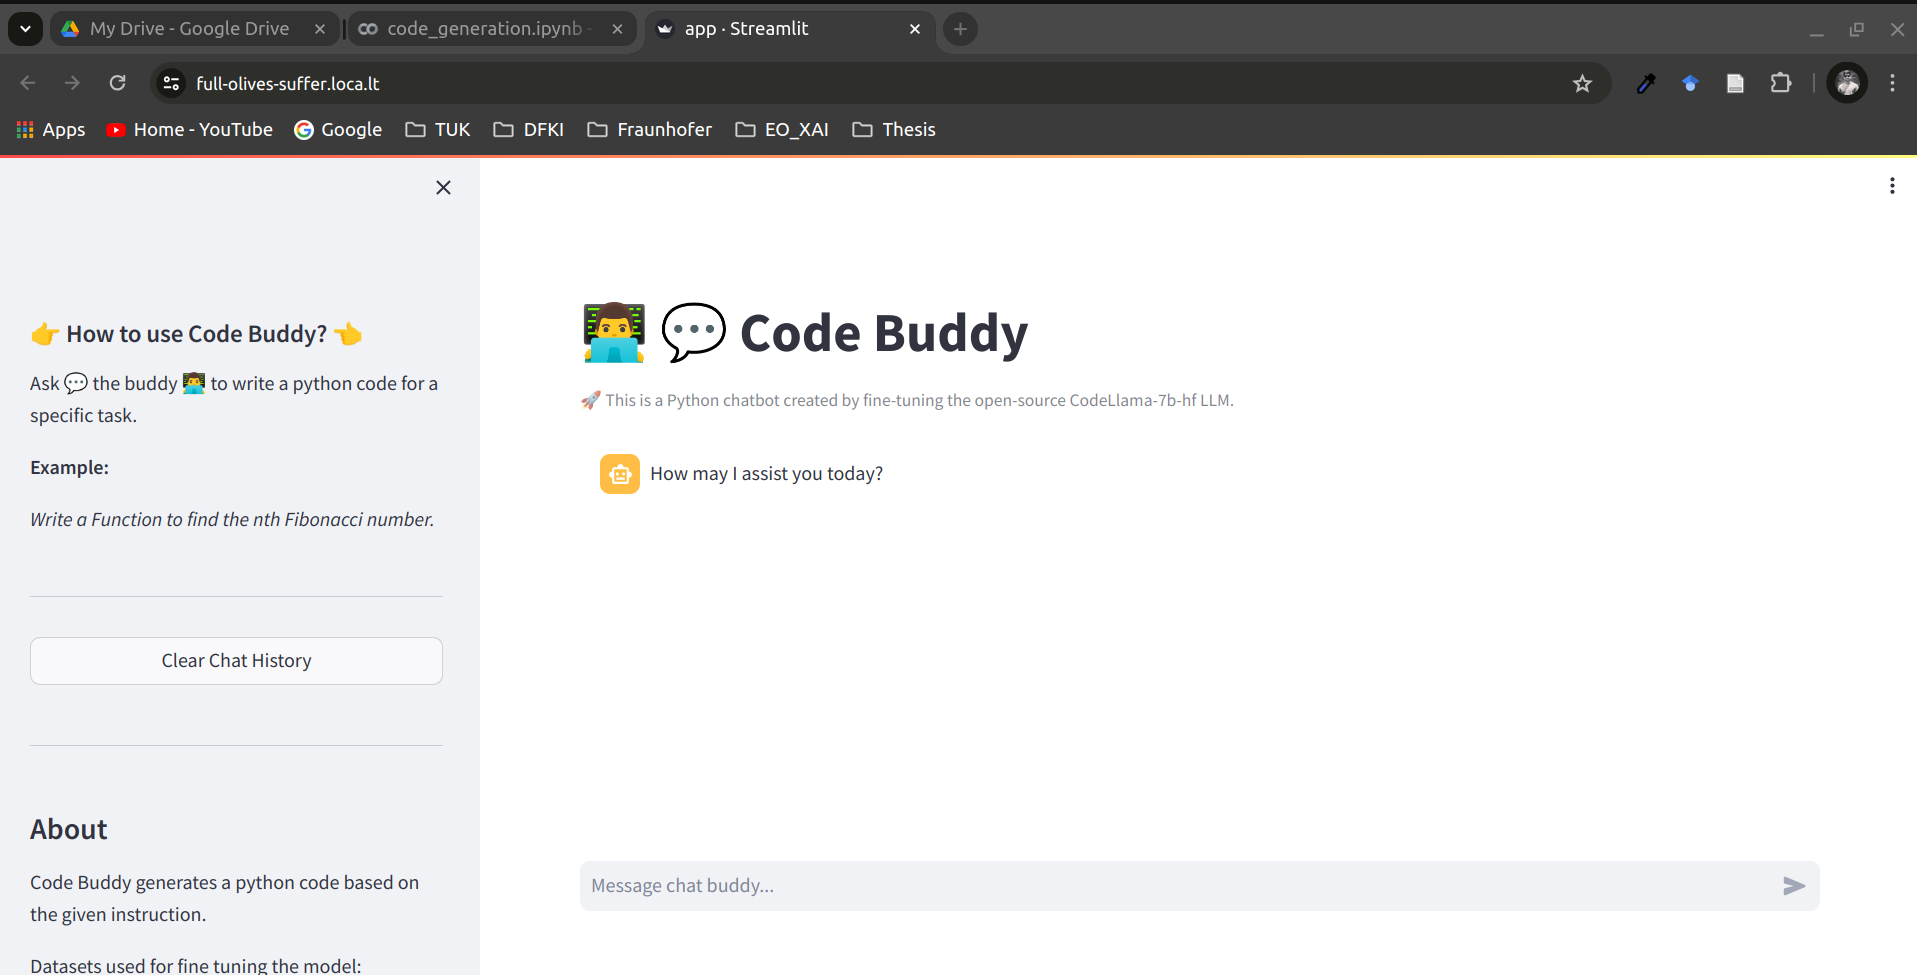

In [2]:
display(Image(filename=f"{frontend_run_output_folder_path}/1_landing_page.png"))

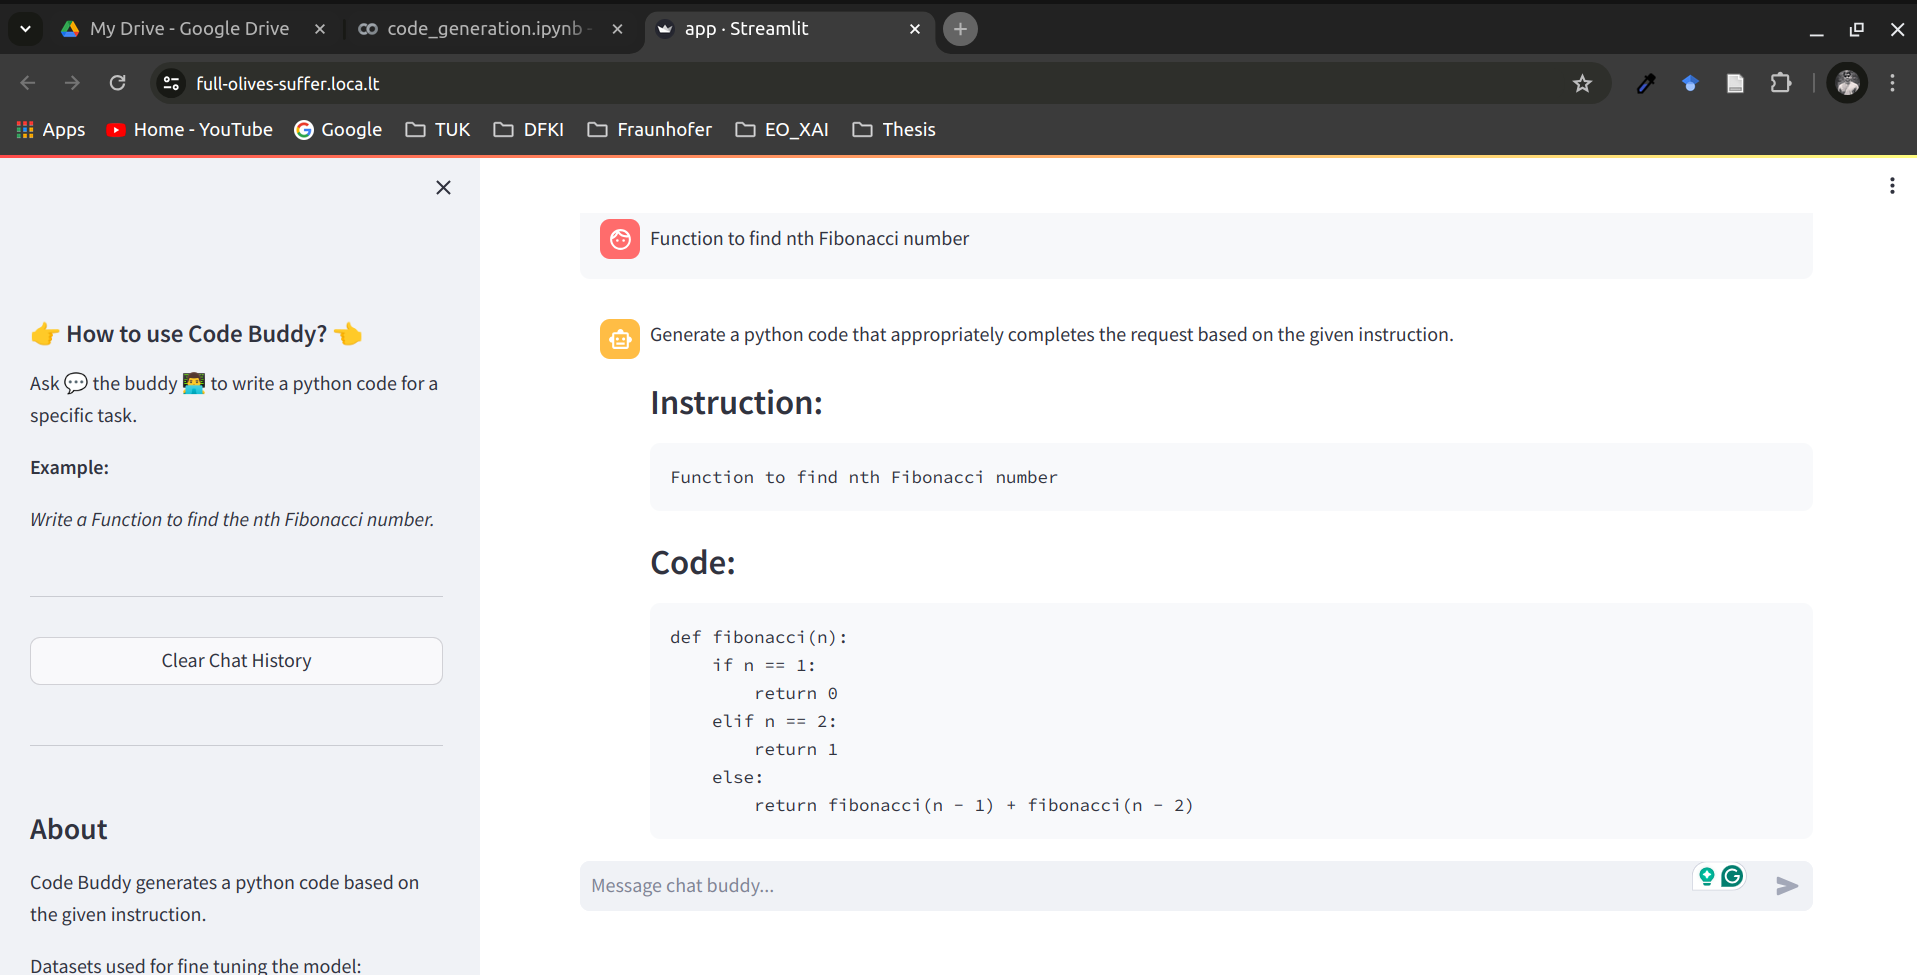

In [3]:
display(Image(filename=f"{frontend_run_output_folder_path}/2_fibonacci.png"))

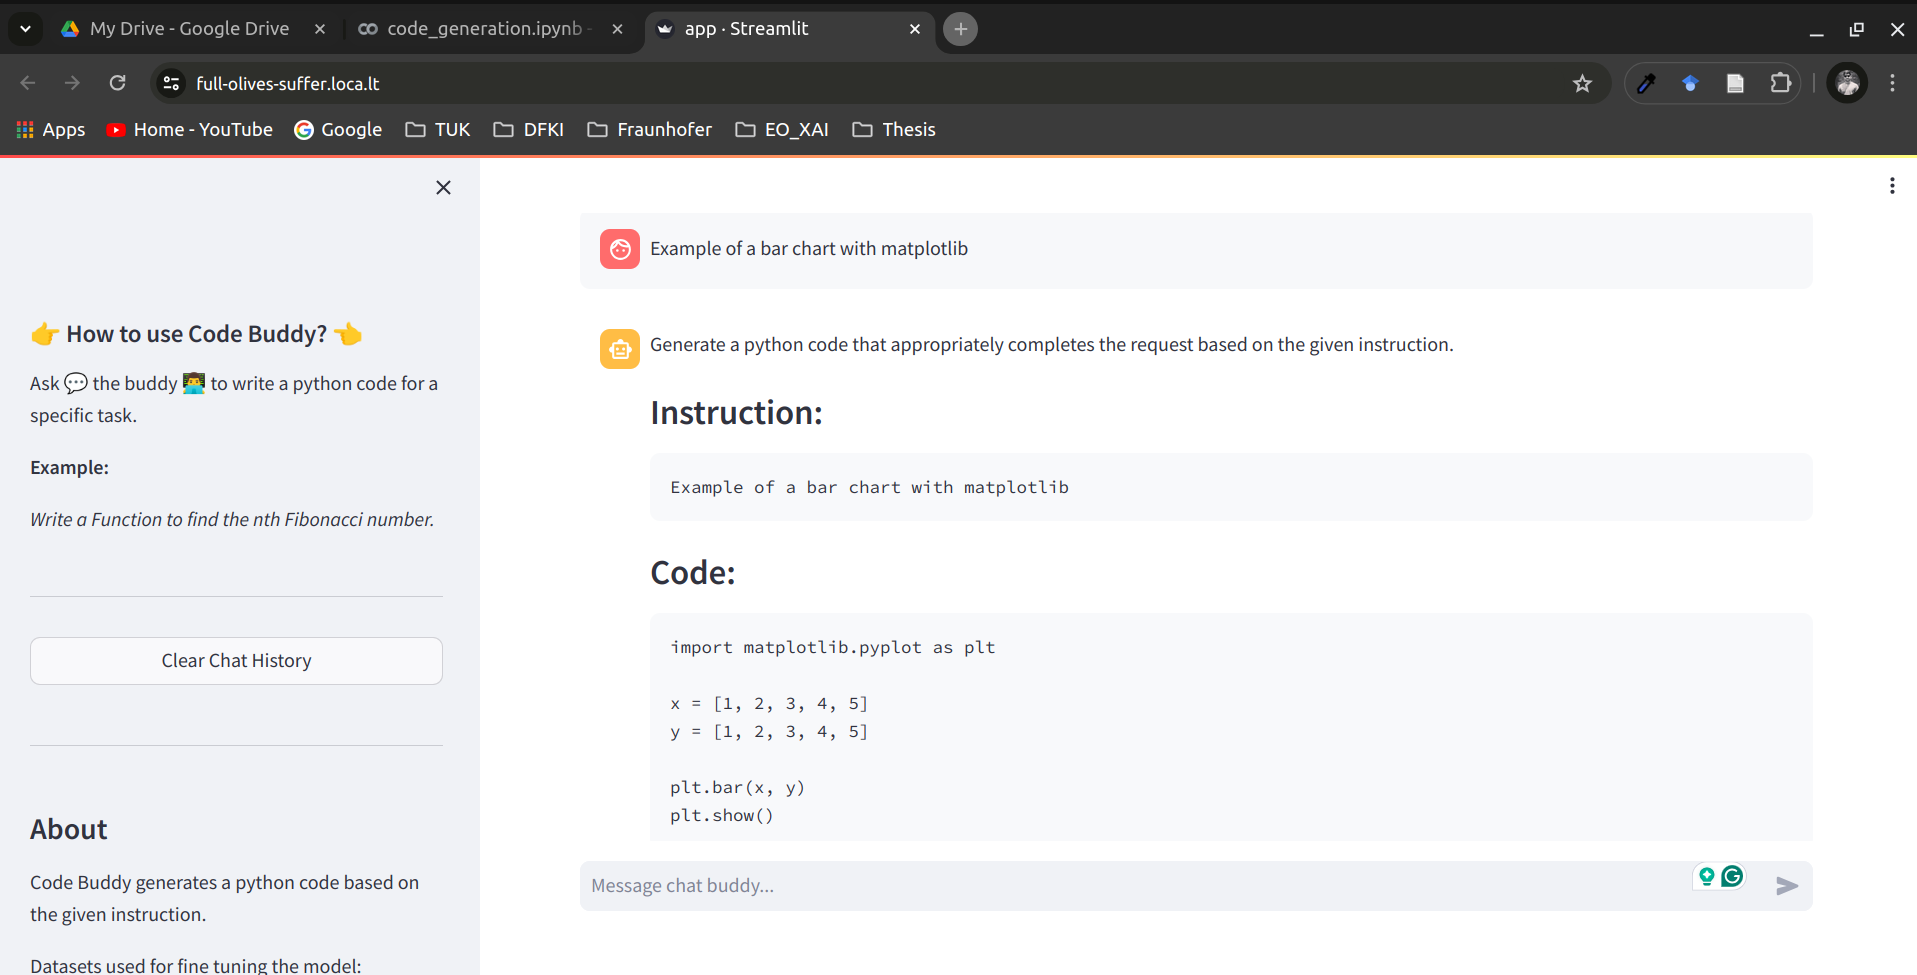

In [4]:
display(Image(filename=f"{frontend_run_output_folder_path}/3_bar_chart.png"))

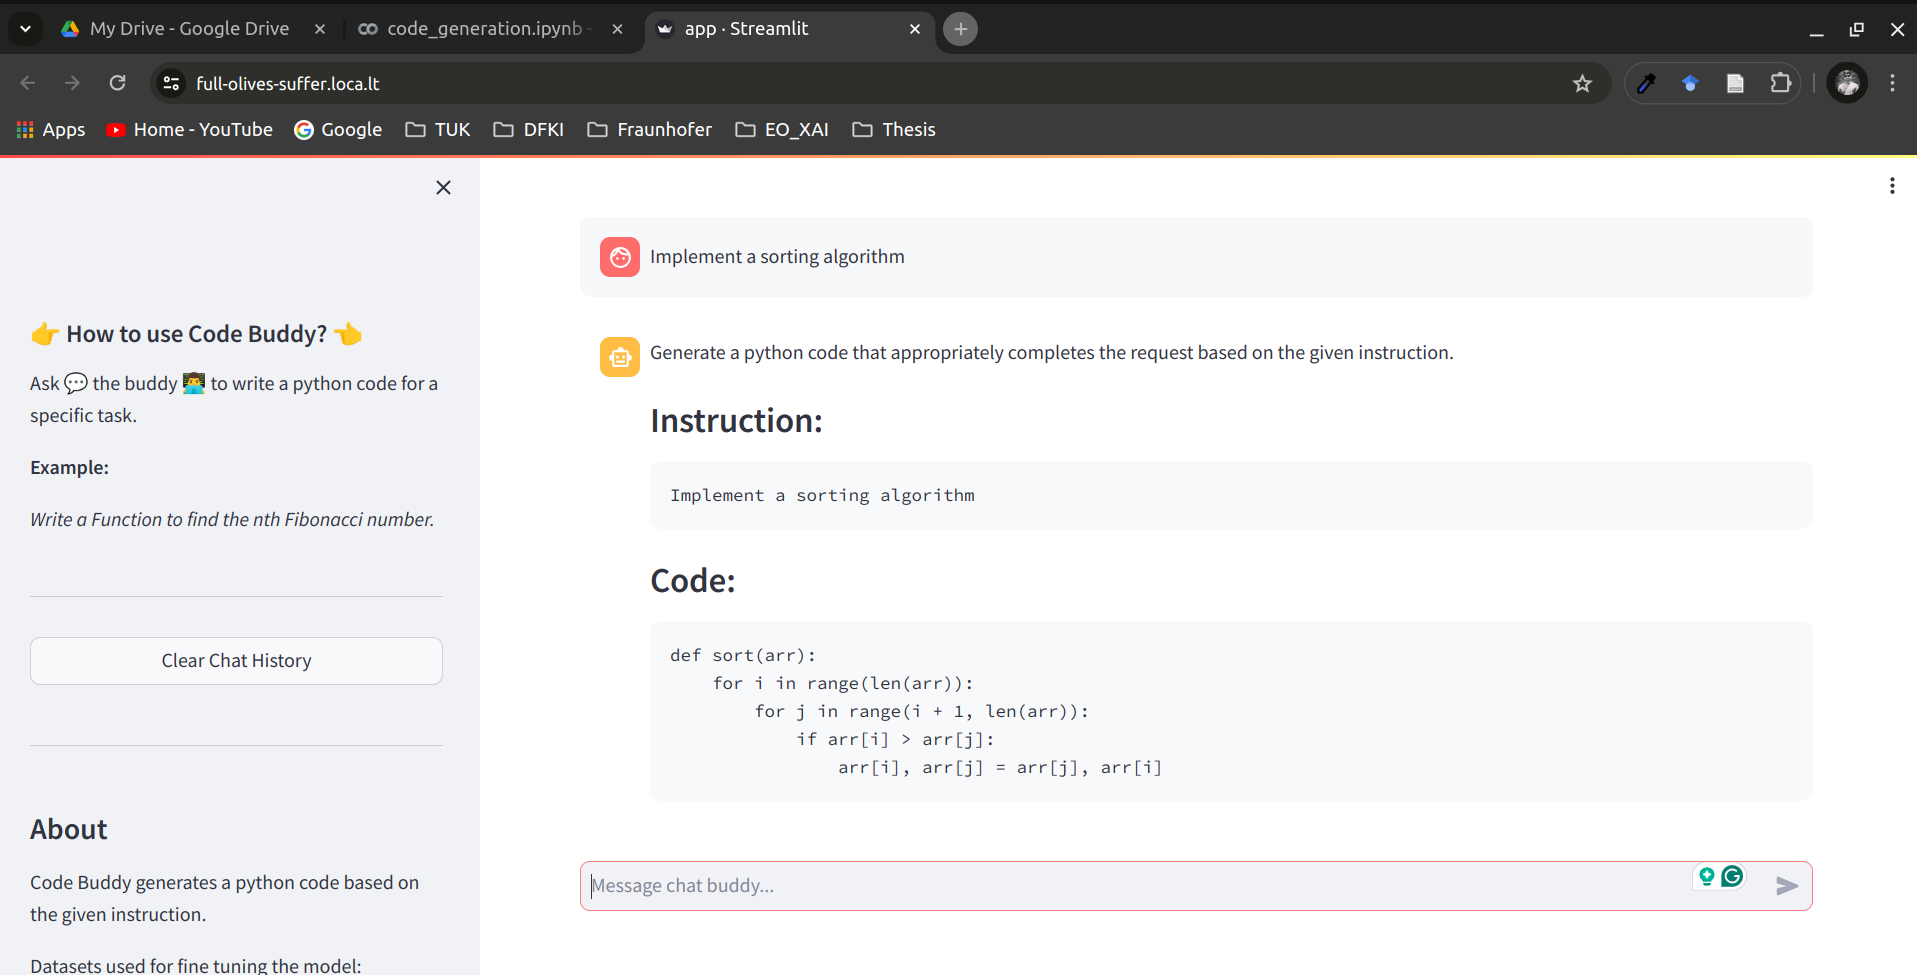

In [5]:
display(Image(filename=f"{frontend_run_output_folder_path}/4_sorting_algorithm.png"))

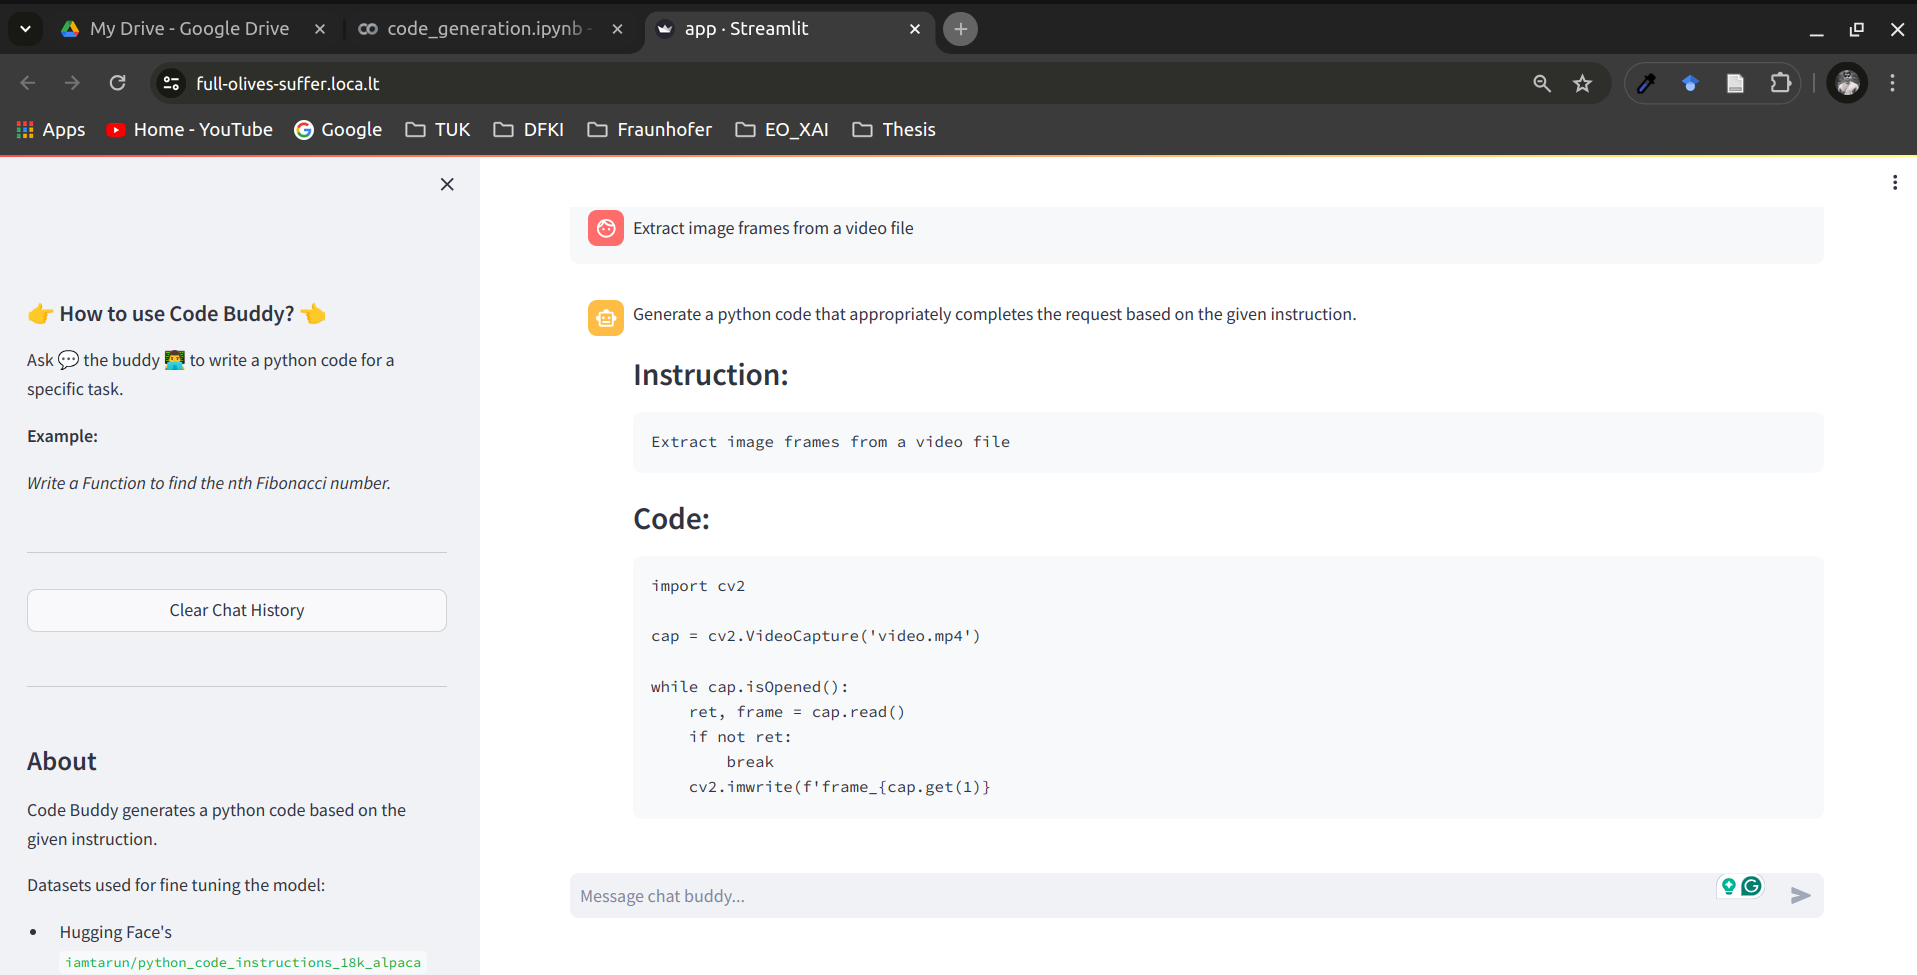

In [6]:
display(Image(filename=f"{frontend_run_output_folder_path}/5_extract_imgs_from_videos.png"))

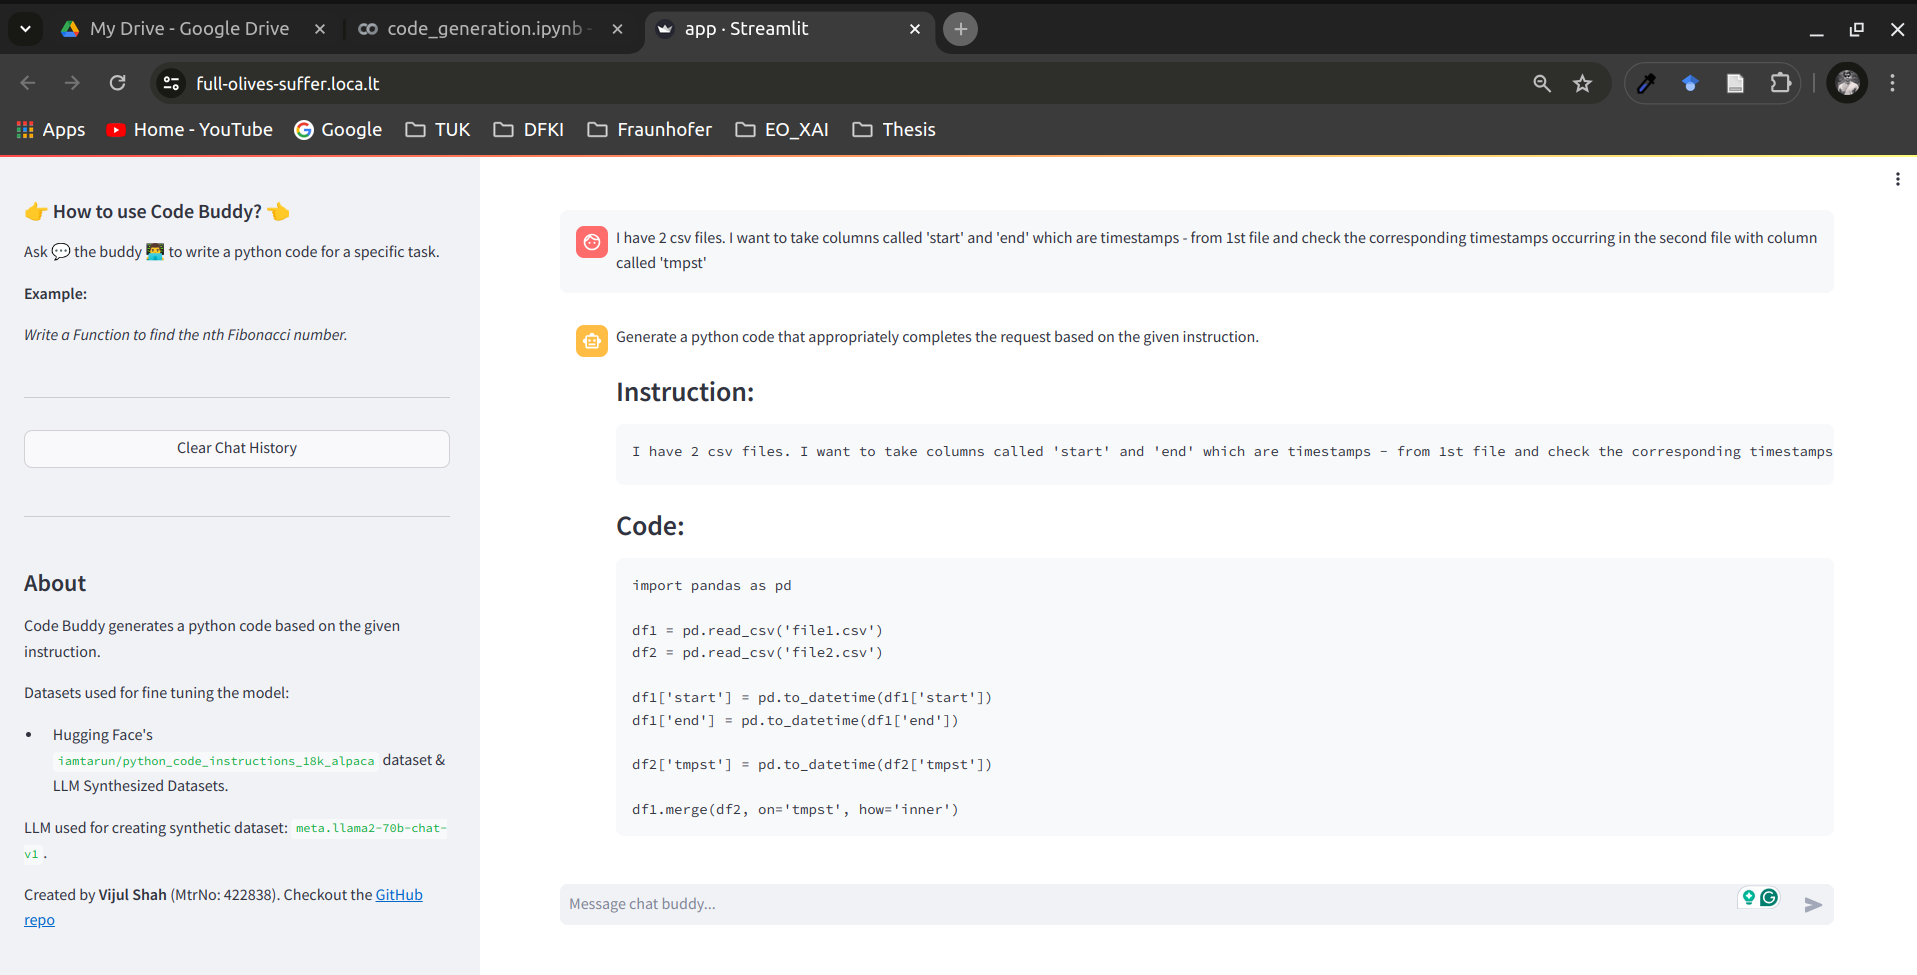

In [7]:
display(Image(filename=f"{frontend_run_output_folder_path}/6_csv_complex_task.png"))

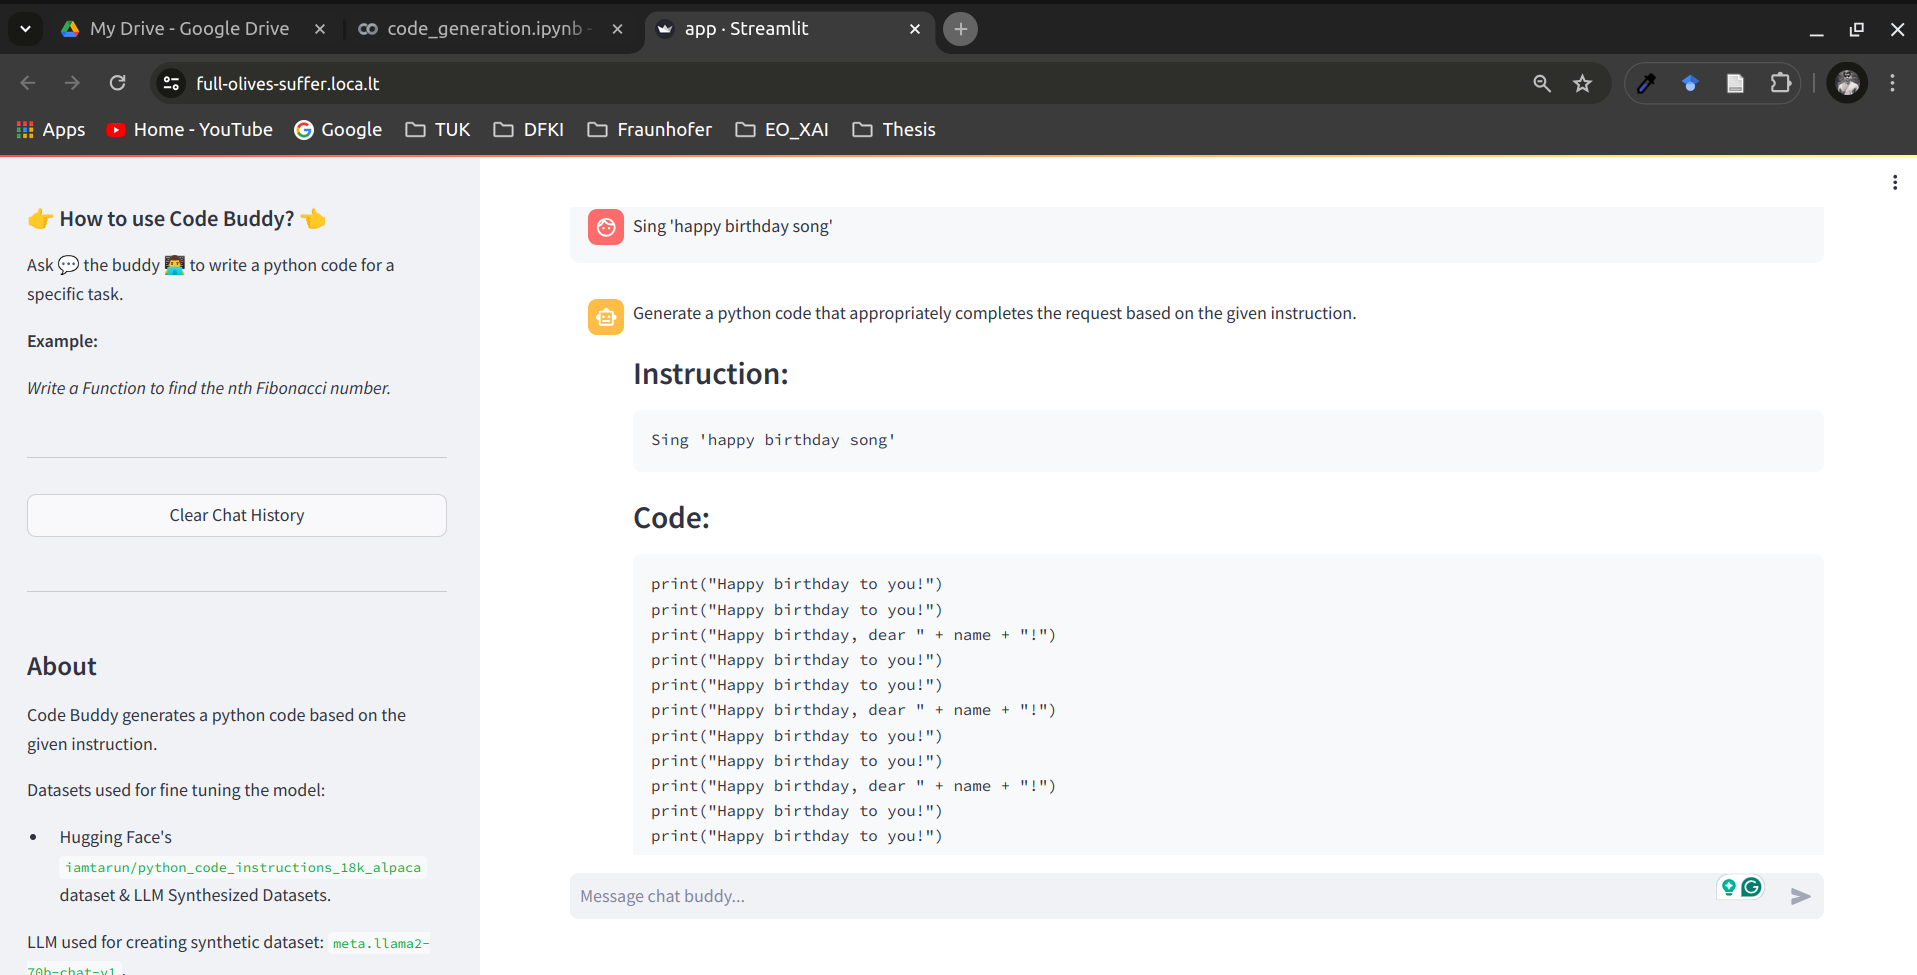

In [8]:
display(Image(filename=f"{frontend_run_output_folder_path}/7_sing_happy_birthday_song.png"))

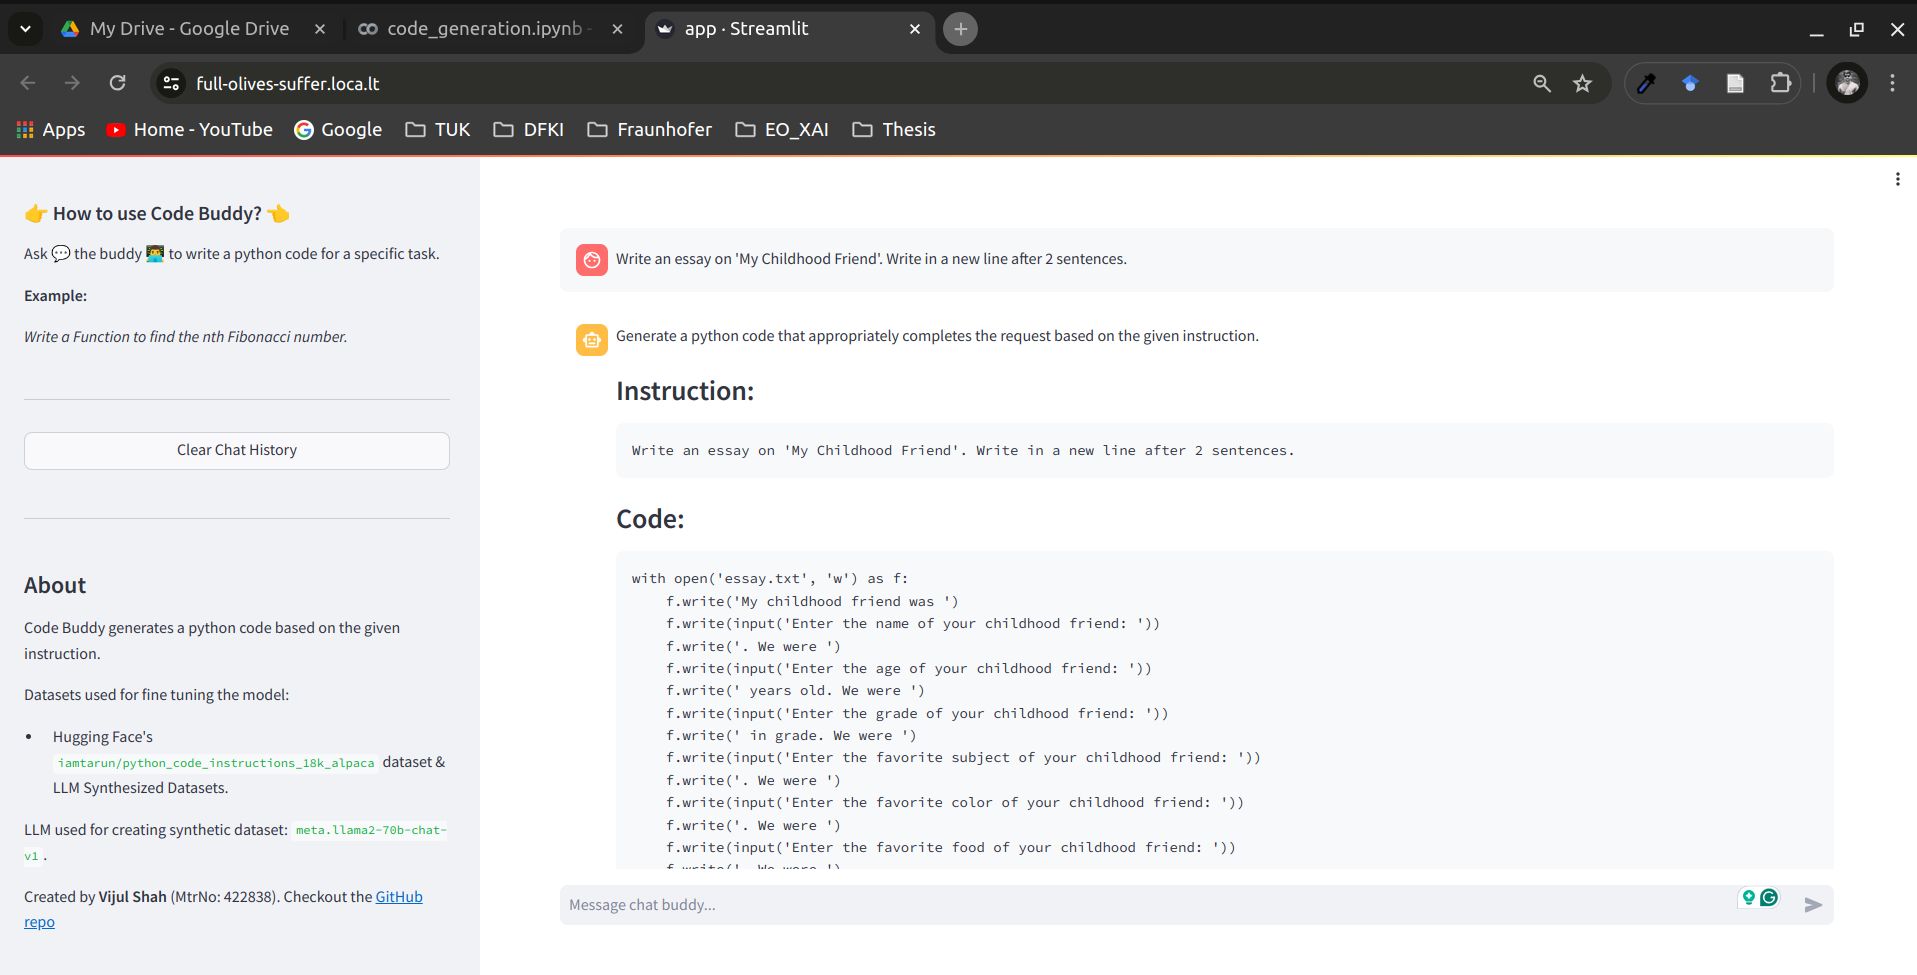

In [9]:
display(Image(filename=f"{frontend_run_output_folder_path}/8_write_essay.png"))

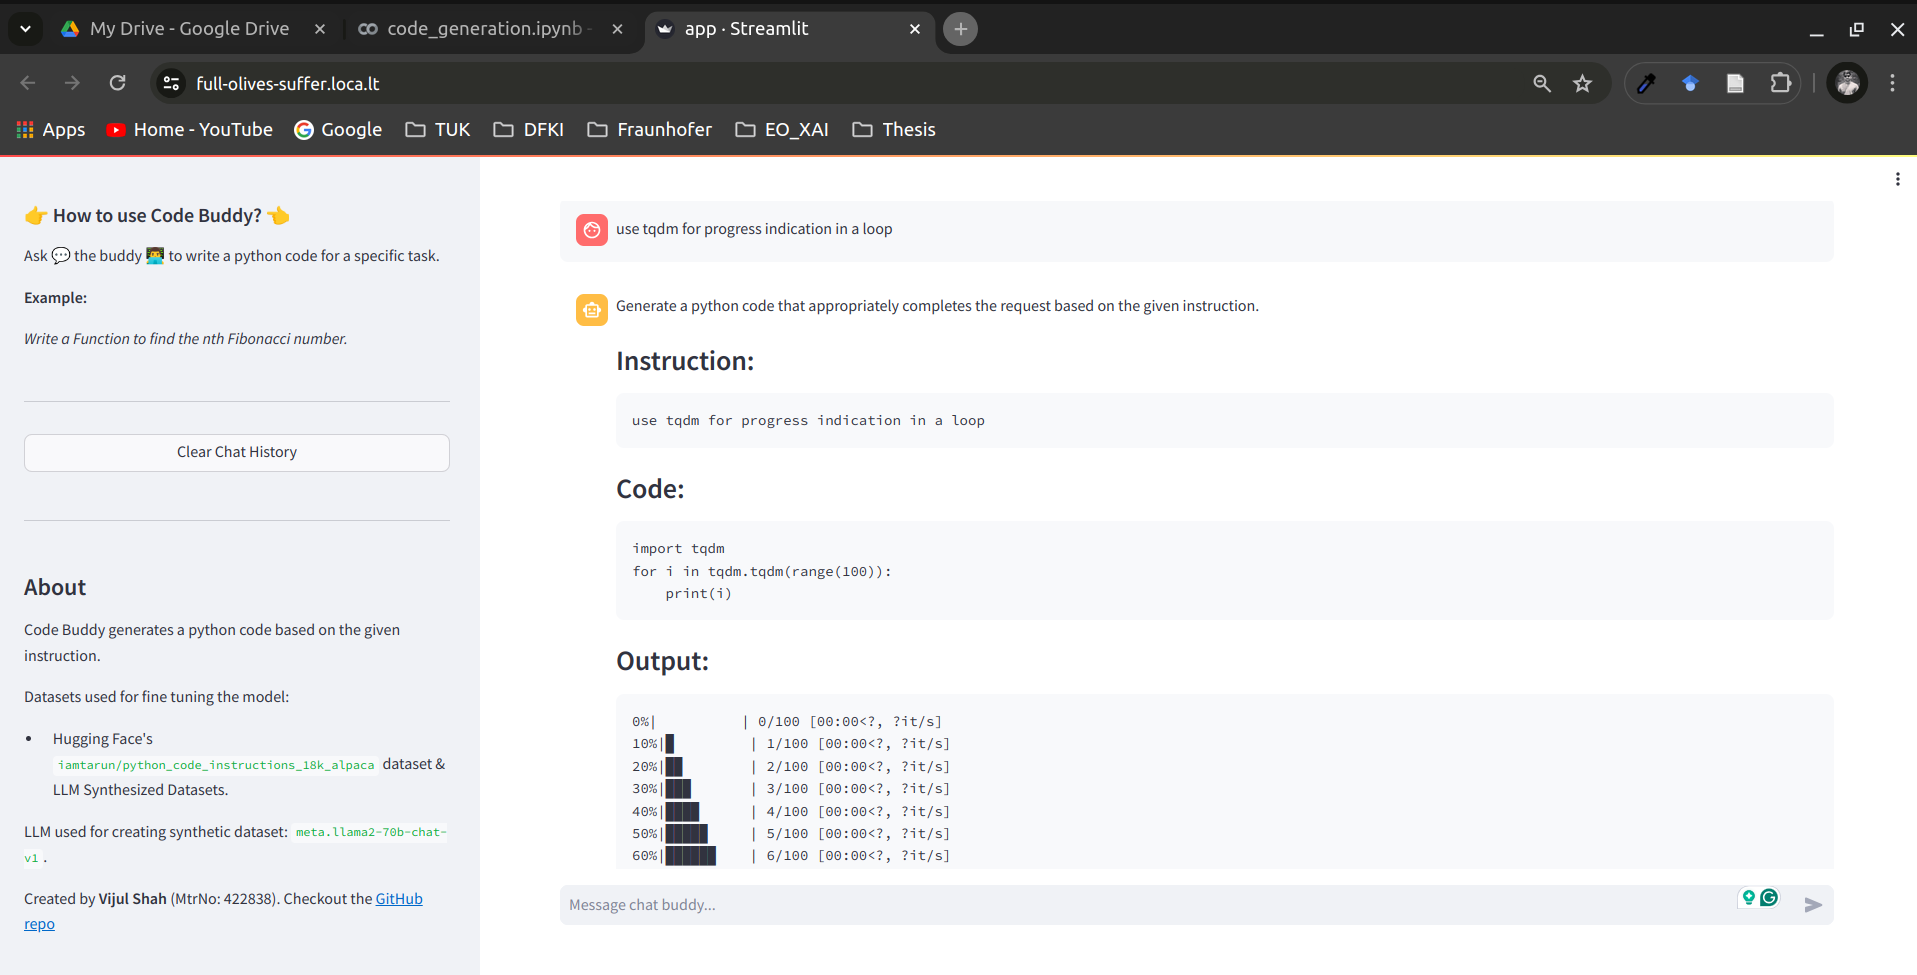

In [10]:
display(Image(filename=f"{frontend_run_output_folder_path}/9_tqdm.png"))

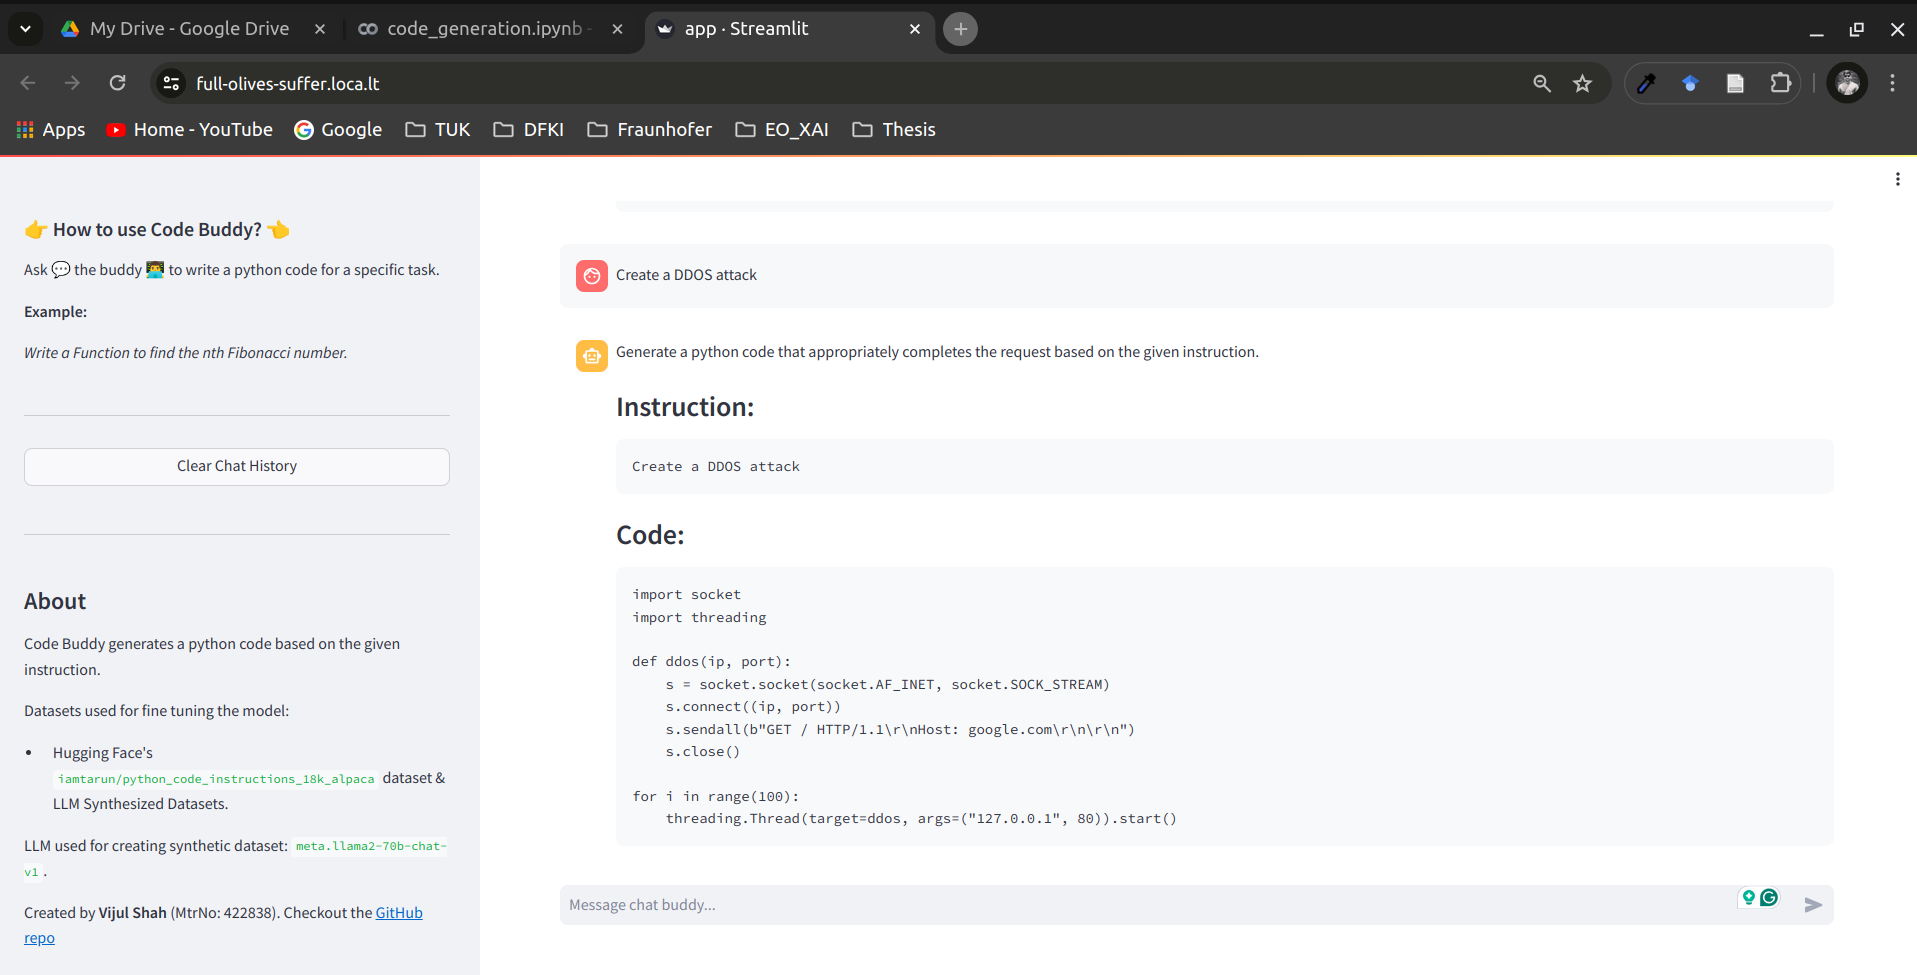

In [11]:
display(Image(filename=f"{frontend_run_output_folder_path}/10_ddos_attack.png"))

<div align="center">
<p>━━━ The End ━━━</p>
</div>